In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize, LogNorm, ListedColormap
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
import seaborn as sns

fontsize = 14

fig_dir = 'figs/'

In [2]:
### get results from WCU reevaluation, after recauculating Pareto set with original 5 objs from MOO
# results = pd.read_csv('../results_arx/infra_wcu/objs_wcu_pareto_5objs_coarse.csv', sep=', ')
results = pd.read_csv('../results_arx/infra_wcu/objs_wcu_pareto_5objs.csv', sep=', ')

### map all costs >2000 to 2000 for visual clarity
for c in ['cog_wp_p90','cog_wp_p50','cog_p_p90','cog_p_p50']:
    results.loc[results[c] > 2000, c] = 2000
results

/tmp/ipykernel_1239/2722700057.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  results = pd.read_csv('../results_arx/infra_wcu/objs_wcu_pareto_5objs.csv', sep=', ')


,label,proj,share_FRS,share_COF,share_TUL,share_KWD,share_EXE,share_LDS,share_LND,share_PRT,...,share_OTL,share_OFK,cwg_p,ap_p,cwg_np,cog_wp_p90,n_p,cog_wp_p50,cog_p_p90,cog_p_p50
0,soln1,3.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,65.286506,25.517769,23.581953,119.515925,3,89.158155,99.563570,77.701771
1,soln100,3.0,0.229613,0.0,0.0,0.028464,0.0,0.042006,0.0,0.000000,...,0.0,0.0,83.519969,60.988011,10.534398,261.605829,14,193.645286,80.755699,61.638616
2,soln1001,3.0,0.157149,0.0,0.0,0.021555,0.0,0.058443,0.0,0.015334,...,0.0,0.0,88.828797,64.907146,5.730221,2000.000000,16,250.040212,79.661088,57.443358
3,soln1004,3.0,0.184161,0.0,0.0,0.015033,0.0,0.082272,0.0,0.033642,...,0.0,0.0,92.460681,68.455763,-9.325362,2000.000000,17,234.514933,76.353268,54.874293
4,soln1005,3.0,0.230880,0.0,0.0,0.021901,0.0,0.000000,0.0,0.013729,...,0.0,0.0,92.651047,58.407270,13.067463,2000.000000,12,167.606488,78.175537,55.627771
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
369,soln988,3.0,0.281544,0.0,0.0,0.100894,0.0,0.000000,0.0,0.000000,...,0.0,0.0,86.194462,51.207598,17.240311,218.698388,8,141.999551,78.078149,58.693952
370,soln989,3.0,0.179659,0.0,0.0,0.038620,0.0,0.000000,0.0,0.000000,...,0.0,0.0,106.223722,47.046693,-4.389908,290.474609,9,180.005108,60.848568,47.246331
371,soln995,3.0,0.194263,0.0,0.0,0.019244,0.0,0.000000,0.0,0.017592,...,0.0,0.0,77.769762,40.167874,20.107271,253.288096,11,159.968357,85.266248,63.624433
372,soln996,3.0,0.265480,0.0,0.0,0.023911,0.0,0.000000,0.0,0.026126,...,0.0,0.0,89.655118,53.916342,15.455185,225.967740,11,161.500598,73.240741,56.707781


In [3]:
shares = results.loc[:,['share' in c for c in results.columns]]
objs = results.iloc[:, -8:]
objs['proj'] = results['proj']
print(shares.columns)
print(objs.columns)

Index(['share_FRS', 'share_COF', 'share_TUL', 'share_KWD', 'share_EXE',
       'share_LDS', 'share_LND', 'share_PRT', 'share_LWT', 'share_TPD',
       'share_SAU', 'share_TBA', 'share_PIX', 'share_DLE', 'share_KRT',
       'share_SSJ', 'share_SFW', 'share_NKN', 'share_ARV', 'share_DLR',
       'share_ID4', 'share_SMI', 'share_TJC', 'share_BLR', 'share_LHL',
       'share_BDM', 'share_WRM', 'share_COB', 'share_BVA', 'share_CWO',
       'share_HML', 'share_KND', 'share_RRB', 'share_CNS', 'share_ALT',
       'share_CWC', 'share_MAD', 'share_SOC', 'share_SOB', 'share_CCA',
       'share_OTL', 'share_OFK'],
      dtype='object')
Index(['cwg_p', 'ap_p', 'cwg_np', 'cog_wp_p90', 'n_p', 'cog_wp_p50',
       'cog_p_p90', 'cog_p_p50', 'proj'],
      dtype='object')


In [4]:
ef_results = pd.read_csv('../results_arx/infra_wcu/objs_wcu_pareto_5objs_coarse_withBaselines.csv', sep=', ').iloc[-3:,:]
### map all costs >2000 to 2000 for visual clarity
for c in ['cog_wp_p90','cog_wp_p50','cog_p_p90','cog_p_p50']:
    ef_results.loc[ef_results[c] > 2000, c] = 2000
    
ef_shares = ef_results.loc[:,['share' in c for c in ef_results.columns]]
ef_objs = ef_results.iloc[:, -8:]
ef_objs['proj'] = ef_results['proj']

/tmp/ipykernel_1239/1602487440.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  ef_results = pd.read_csv('../results_arx/infra_wcu/objs_wcu_pareto_5objs_coarse_withBaselines.csv', sep=', ').iloc[-3:,:]


In [5]:
ef_results

,label,proj,share_FRS,share_COF,share_TUL,share_KWD,share_EXE,share_LDS,share_LND,share_PRT,...,share_OTL,share_OFK,cwg_p,ap_p,cwg_np,cog_wp_p90,n_p,cog_wp_p50,cog_p_p90,cog_p_p50
96,friant16,1.0,0.02289,0.061623,0.073846,0.0,0.017611,0.028244,0.040608,0.025589,...,0.000000,0.075813,50.793163,40.140243,-0.592862,2000.000000,16,2000.000000,71.834523,50.754024
97,alt3,3.0,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,77.502383,40.984979,6.211429,113.757334,3,86.769882,84.238906,66.701589
98,alt8,3.0,0.00000,0.000000,0.022338,0.0,0.000000,0.000000,0.000000,0.000000,...,0.149274,0.000000,44.914626,25.288021,2.640060,2000.000000,8,300.739962,243.816583,105.374187


In [6]:
# sns.pairplot(objs, hue='proj', vars=['cwg_p', 'ap_p', 'cwg_np', 'cog_wp_p90', 'n_p'])
# sns.pairplot(objs, hue='proj', vars=['cwg_p', 'ap_p', 'cwg_np', 'cog_wp_p50', 'n_p'])
# sns.pairplot(objs, hue='proj', vars=['cwg_p', 'ap_p', 'cwg_np', 'cog_p_p90', 'n_p'])
# sns.pairplot(objs, hue='proj', vars=['cwg_p', 'ap_p', 'cwg_np', 'cog_p_p50', 'n_p'])
# sns.pairplot(objs, hue='proj', vars=['cwg_p', 'ap_p', 'cwg_np', 'n_p', 'cog_wp_p90', 'cog_wp_p50', 'cog_p_p90', 'cog_p_p50'])

/tmp/ipykernel_1239/1301877188.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ressat = ressat.append(ef_results.loc[:,cols])


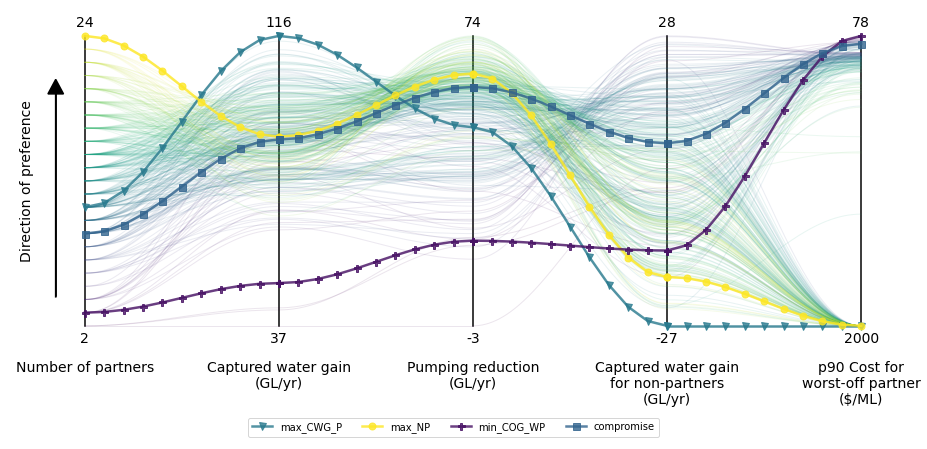

In [7]:
### reorganize for parallel coordinate plot
cost_type = 'cog_wp_p90'
fig_stage = 6   # 0 = axes only, 1 = friant16 only, 2 = friant16+alt3+alt8, 3 = all w/ hilite friant16+alt3+alt8, 
                #       4 = all brushed except friant16+alt3+alt8, 5 = all except friant16+alt3+alt8,
                #       6 = all w/ hilite maxs+compromise
        
ideal = 'top'

cols = ['n_p', 'cwg_p', 'ap_p', 'cwg_np', cost_type]
cost_type_labels = {'cog_wp_p90': 'p90 Cost for\nworst-off partner\n($/ML)',
                   'cog_wp_p50': 'Median cost of gains,\nworst-off\npartner\n($/ML)',
                   'cog_p_p90': '90%ile cost of gains,\npartnership\n($/ML)',
                   'cog_p_p50': 'Median cost of gains,\npartnership\n($/ML)'}
ressat = results.loc[:,cols]
ressat = ressat.append(ef_results.loc[:,cols])

ideal = 'top'


if ideal == 'bottom':
    tops = ressat.min(axis=0)
    bottoms = ressat.max(axis=0)
    switch = bottoms[-1]
    bottoms[-1] = tops[-1]
    tops[-1] = switch
    ressat.iloc[:, :-1] = (ressat.iloc[:, :-1].max(axis=0) - ressat.iloc[:, :-1]) / (ressat.iloc[:, :-1].max(axis=0) - ressat.iloc[:, :-1].min(axis=0))
    ressat.iloc[:, -1] = (ressat.iloc[:, -1] - ressat.iloc[:, -1].min(axis=0)) / (ressat.iloc[:, -1].max(axis=0) - ressat.iloc[:, -1].min(axis=0))
elif ideal == 'top':
    tops = ressat.max(axis=0)
    bottoms = ressat.min(axis=0)
    switch = bottoms[-1]
    bottoms[-1] = tops[-1]
    tops[-1] = switch
    ressat.iloc[:, -1] = (ressat.iloc[:, -1].max(axis=0) - ressat.iloc[:, -1]) / (ressat.iloc[:, -1].max(axis=0) - ressat.iloc[:, -1].min(axis=0))
    ressat.iloc[:, :-1] = (ressat.iloc[:, :-1] - ressat.iloc[:, :-1].min(axis=0)) / (ressat.iloc[:, :-1].max(axis=0) - ressat.iloc[:, :-1].min(axis=0))
else:
    print('ideal should be "top" or "bottom" based on direction of preference')
    
### parallel coord plot
fig,ax = plt.subplots(1,1,figsize=(16,8), gridspec_kw={'hspace':0.1, 'wspace':0.1})

colnorm = 0
### plot all satisficing solns
for i in range(ressat.shape[0]):
    for j in range(len(cols)-1):
        numnorm = ressat.iloc[i,colnorm]  / ressat.iloc[:,colnorm].max() #*0.9
        c = cm.get_cmap('viridis')(numnorm)
        ### add sin shape to help distinguish lines
        y1 = ressat.iloc[i, j]
        y2 = ressat.iloc[i, j+1]
        t = np.arange(-np.pi/2, np.pi/2+0.001, 0.01)
        y = y1 + (np.sin(t) + 1) / 2 * (y2 - y1)
        x = j + t / np.pi + 1/2
        if fig_stage < 3:
            alpha = 0
        elif fig_stage in (4,6):
            alpha = 0.1
        else:
            alpha=0.8
        if i < ressat.shape[0] - 3:
            ### plot solns from MOO/WCU
            ax.plot(x, y, c=c, alpha=alpha, zorder=2+numnorm, lw=1)
        ### plot extra solns from EF paper
        if fig_stage < 5:
            lsdict = {ressat.shape[0]-3: '-', ressat.shape[0]-2: '--', ressat.shape[0]-1: ':'}
            if i == ressat.shape[0] - 3:    
                if fig_stage > 0:
                    ax.plot(x, y, c='k', alpha=1, zorder=4, lw=2, ls=lsdict[i])
            elif i > ressat.shape[0] - 3:
                if fig_stage > 1:
                    ax.plot(x, y, c='k', alpha=1, zorder=4, lw=2, ls=lsdict[i])

                    
### hilite example solns from WCU
if fig_stage > 5:
    solns = ['soln196', 'soln1224', 'soln2', 'soln599']
    labels = ['max_NP', 'max_CWG_P', 'min_COG_WP', 'compromise']
    label_dict = {solns[i]:labels[i] for i in range(4)}
    marker_dict = {solns[i]:['o', 'v', 'P', 's'][i] for i in range(4)}
    ### plot all satisficing solns
    for i in range(ressat.shape[0]-3):
        if results['label'].iloc[i] in solns:
            soln = results['label'].iloc[i]
            for j in range(len(cols)-1):
                numnorm = ressat.iloc[i,colnorm]  / ressat.iloc[:,colnorm].max() #*0.9
                c = cm.get_cmap('viridis')(numnorm)
                ### add sin shape to help distinguish lines
                y1 = ressat.iloc[i, j]
                y2 = ressat.iloc[i, j+1]
                t = np.arange(-np.pi/2, np.pi/2+0.001, np.pi/10)
                y = y1 + (np.sin(t) + 1) / 2 * (y2 - y1)
                x = j + t / np.pi + 1/2
                alpha=0.8
                if j == 0:
                    ax.plot(x, y, c=c, alpha=alpha, zorder=3, lw=2.5, marker=marker_dict[soln], ms=7, label=label_dict[soln])
                else:
                    ax.plot(x, y, c=c, alpha=alpha, zorder=3, lw=2.5, marker=marker_dict[soln], ms=7)
                    
    ax.legend(ncol=4, loc='lower center')
                

### add top/bottom ranges
for j in range(len(cols)):
    ax.annotate(str(round(tops[j])), [j, 1.02], ha='center', va='bottom', zorder=5, fontsize=fontsize)
    ax.annotate(str(round(bottoms[j])), [j, -0.02], ha='center', va='top', zorder=5, fontsize=fontsize)    
    ax.plot([j,j], [0,1], c='k', zorder=1)
ax.set_xticks([])
ax.set_yticks([])
for spine in ['top','bottom','left','right']:
    ax.spines[spine].set_visible(False)

if ideal == 'top':
    ax.arrow(-0.15,0.1,0,0.7, head_width=0.08, head_length=0.05, color='k', lw=1.5)
elif ideal == 'bottom':
    ax.arrow(-0.15,0.9,0,-0.7, head_width=0.08, head_length=0.05, color='k', lw=1.5)
    
ax.annotate('Direction of preference', xy=(-0.3,0.5), ha='center', va='center', rotation=90, fontsize=fontsize)

ax.set_xlim(-0.4, 4.2)
ax.set_ylim(-0.4,1.1)
labels = ['Number of partners', 'Captured water gain\n(GL/yr)', 'Pumping reduction\n(GL/yr)', 
          'Captured water gain\nfor non-partners\n(GL/yr)',cost_type_labels[cost_type]]
for i,l in enumerate(labels):
    ax.annotate(l, xy=(i,-0.12), ha='center', va='top', fontsize=fontsize)

plt.savefig(f'{fig_dir}paraxis_{fig_stage}.png', bbox_inches='tight', dpi=300)


In [8]:
df_shares = shares
df_stats = df_shares.describe()
### first sort by median
order = df_stats.loc['50%'].sort_values(ascending=False).index
df_stats = df_stats[order]
### for those with zero median, sort by 75%
num_nonzero = sum([df_stats.loc['50%', order[i]] > 0 for i in range(len(order))])
order = list(order[:num_nonzero]) + list(df_stats.loc['75%', order[num_nonzero:]].sort_values(ascending=False).index)
df_stats = df_stats[order]
### for those with zero 75%, sort by max
num_nonzero = sum([df_stats.loc['75%', order[i]] > 0 for i in range(len(order))])
order = list(order[:num_nonzero]) + list(df_stats.loc['max', order[num_nonzero:]].sort_values(ascending=False).index)
df_stats = df_stats[order]

df_shares = df_shares.loc[:, order]
df_shares.reset_index(inplace=True, drop=True)

(array([-0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

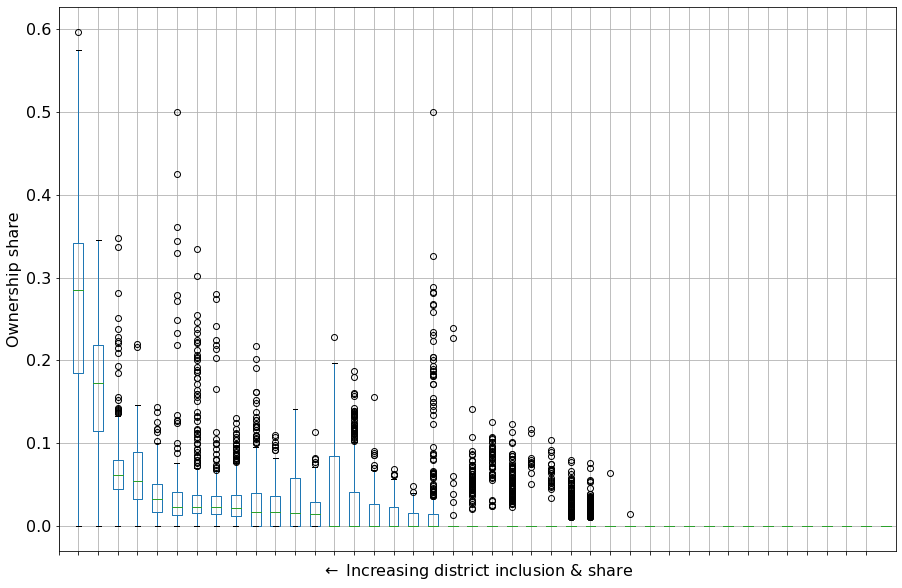

In [9]:
plt.figure(figsize=(15,10))
df_shares.boxplot()
dum = plt.xticks(rotation=90)
plt.xticks(range(df_shares.shape[1]), labels=[])
plt.xlabel(r'$\leftarrow$ Increasing district inclusion & share', fontsize=16)
plt.ylabel('Ownership share', fontsize=16)
plt.yticks(fontsize=16)

In [10]:
df_shares = shares.loc[:, shares.sum(axis=0) > 0]
df_stats = df_shares.describe()
### first sort by median
order = df_stats.loc['50%'].sort_values(ascending=False).index
df_stats = df_stats[order]
### for those with zero median, sort by 75%
num_nonzero = sum([df_stats.loc['50%', order[i]] > 0 for i in range(len(order))])
order = list(order[:num_nonzero]) + list(df_stats.loc['75%', order[num_nonzero:]].sort_values(ascending=False).index)
df_stats = df_stats[order]
### for those with zero 75%, sort by max
num_nonzero = sum([df_stats.loc['75%', order[i]] > 0 for i in range(len(order))])
order = list(order[:num_nonzero]) + list(df_stats.loc['max', order[num_nonzero:]].sort_values(ascending=False).index)
df_stats = df_stats[order]

df_shares = df_shares.loc[:, order]
df_shares.reset_index(inplace=True, drop=True)

### sort df_shares by N_P
df_shares = df_shares.iloc[objs.sort_values(['n_p', 'cwg_p'], ascending=False).index, :].reset_index(drop=True)

### patches plot, showing shares in different solutions. use custom scale
ndistricts = df_shares.shape[1] 
nsolns = df_shares.shape[0]
cmap = cm.get_cmap('YlGnBu')
oldcolors = cmap(np.linspace(0.15, 1, 6))
# cmap = cm.get_cmap('viridis_r')
# oldcolors = cmap(np.linspace(0, 1, 6))
newcolors = cmap(np.linspace(0, 1, 2560))
breaks = [int(2560 * b) for b in [0.01,0.03, 0.07, 0.15, 0.3, 1]]
newcolors[:breaks[0]] = [0.8,0.8,0.8, 1]
for i , b in enumerate(breaks[:-1]):
    newcolors[b:breaks[i+1]] = oldcolors[i]
cmap_class = ListedColormap(newcolors)
mappable = cm.ScalarMappable(cmap=cmap_class)

### separate cmap class with even intervals for colorbar
breaks_even = [int(2560 * b) for b in [1/6,2/6,3/6,4/6,5/6,1]]
newcolors_even = cmap(np.linspace(0, 1, 2560))
newcolors_even[:breaks_even[0]] = [0.8,0.8,0.8, 1]
for i , b in enumerate(breaks_even[:-1]):
    newcolors_even[b:b+10] = [0,0,0,1]
    newcolors_even[b+10:breaks_even[i+1]] = oldcolors[i]
cmap_class_even = ListedColormap(newcolors_even)

mappable_even = cm.ScalarMappable(cmap=cmap_class_even)

# fig, ax = plt.subplots(1, figsize=(16,8))
# shareboxes = []
# colors = []
# for d in range(ndistricts):
#     for s in range(nsolns):
#         share = df_shares.iloc[s, d]
#         shareboxes = [Rectangle((s, ndistricts - d - 1), 1, 1)]
#         color = cmap_class(share)
#         if share == 0.:
#             alpha = 0
#         else:
#             alpha = 1
# #         pc = PatchCollection(shareboxes, facecolor=color, edgecolor='k', alpha=alpha)
#         pc = PatchCollection(shareboxes, facecolor=color, alpha=alpha)
#         ax.add_collection(pc)
# ax.set_xlim([0,nsolns])
# ax.set_ylim([0,ndistricts])
# ax.set_xticks([])
# ax.set_xlabel(r'$\leftarrow$ Increasing size of partnership', fontsize=16)
# ax.set_ylabel(r'Increasing district inclusion & share $\rightarrow$', fontsize=16)
# # _ = ax.set_yticks(np.arange(ndistricts - 0.5, 0, -1), [s.split('_')[1] for s in df_shares.columns[:-1]], fontsize='14')
# _ = ax.set_yticks(np.arange(ndistricts - 0.5, 0, -1), labels=[], fontsize='14')
# cb = plt.colorbar(sm, ax=ax, ticks=[0.01,0.03, 0.07, 0.15, 0.3,0.6])
# _ = cb.ax.set_yticklabels([1,3,7,15,30,60], fontsize=16)
# _ = cb.set_label('ownership share (%)', fontsize=16)
# _ = cb.ax.set_ylim([0.01,0.6])


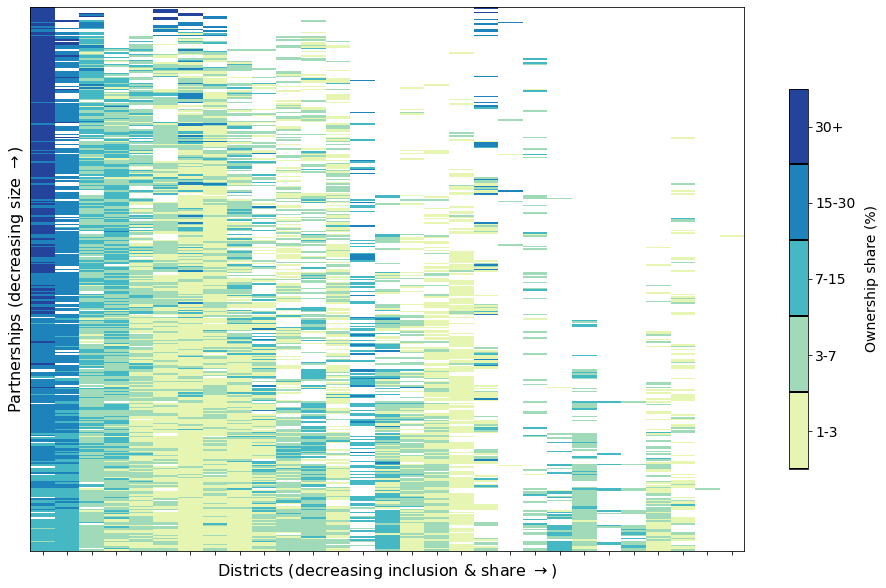

In [11]:
### quilt plot
fig_stage = 3   # 0 = none, 1 = single soln, 2 = single district, 3 = all 

fig, ax = plt.subplots(1, figsize=(16,10))
shareboxes = []
colors = []
for d in range(ndistricts):
    for s in range(nsolns):
        share = df_shares.iloc[s, d]
        color = cmap_class(share)
        if share == 0.:
            alpha = 0
        else:
            alpha = 1
        shareboxes = [Rectangle((d, s), 1, 1)]
        
        if fig_stage == 0:
            alpha = 0
        elif fig_stage == 1:
            if s != int(nsolns/2):
                alpha = 0
            shareboxes = [Rectangle((d, s-6), 1, 7)]
        elif fig_stage == 2:
            if d != int(ndistricts/2):
                alpha = 0
            
        
#         pc = PatchCollection(shareboxes, facecolor=color, edgecolor='k', alpha=alpha)
        pc = PatchCollection(shareboxes, facecolor=color, alpha=alpha)
        ax.add_collection(pc)
        
ax.set_ylim([0,nsolns])
ax.set_xlim([0,ndistricts])
ax.set_yticks([])
ax.set_ylabel(r'Partnerships (decreasing size $\rightarrow$)', fontsize=16)
ax.set_xlabel(r'Districts (decreasing inclusion & share $\rightarrow$)', fontsize=16)
# _ = ax.set_yticks(np.arange(ndistricts - 0.5, 0, -1), [s.split('_')[1] for s in df_shares.columns[:-1]], fontsize=16)
_ = ax.set_xticks(np.arange(ndistricts - 0.5, 0, -1), labels=[], fontsize=16)

cb = plt.colorbar(mappable_even, ax=ax, ticks=[3/12,5/12,7/12,9/12,11/12], shrink=0.7)
_ = cb.ax.set_yticklabels(['1-3', '3-7','7-15','15-30','30+',], fontsize=fontsize)
_ = cb.set_label('Ownership share (%)', fontsize=fontsize, labelpad=10)
_ = cb.ax.set_ylim([2/12,1])

plt.savefig(f'{fig_dir}ownership_quilt_{fig_stage}.png', bbox_inches='tight', dpi=300)


In [12]:
# https://chart-studio.plotly.com/~empet/15191/texas-bivariate-choropleth-assoc/#/
jstevens = ["#e8e8e8", "#ace4e4", "#5ac8c8", "#dfb0d6", "#a5add3", 
            "#5698b9", "#be64ac", "#8c62aa", "#3b4994"]  # second example, pink/aqua

# jstevens = ["#e8e8e8", "#e4acac", "#c85a5a", "#b0d5df", "#ad9ea5", 
#             "#985356", "#64acbe", "#627f8c", "#574249"]  # first example, blue/red

# jstevens = ["#e8e8e8", "#b0d5df",  "#64acbe", "#e4acac", "#ad9ea5", 
#             "#627f8c", "#c85a5a", "#985356","#574249"]  # first example, but transpose

share_bounds = [0.05, 0.1, 1]
inclusion_bounds = [0.25, 0.75, 1]

# jstevens = ['#E8E8E8', '#C5E0E0', '#A1D8D8', '#7ED0D0', '#5AC8C8',
#             '#DEC7D9', '#BBBFD2', '#98B8CA', '#75B0C3', '#52A8BB',
#             '#D3A6CA', '#B19FC3', '#8F98BC', '#6D90B5', '#4B89AE',
#             '#C985BB', '#A87EB5', '#8677AE', '#6570A8', '#4369A1',
#             '#BE64AC', '#9D5DA6', '#7D57A0', '#5C509A', '#3B4994']
# share_bounds = [0.01, 0.03, 0.07, 0.15, 1]
# inclusion_bounds = [0.01, 0.25, 0.5, 0.75, 1]


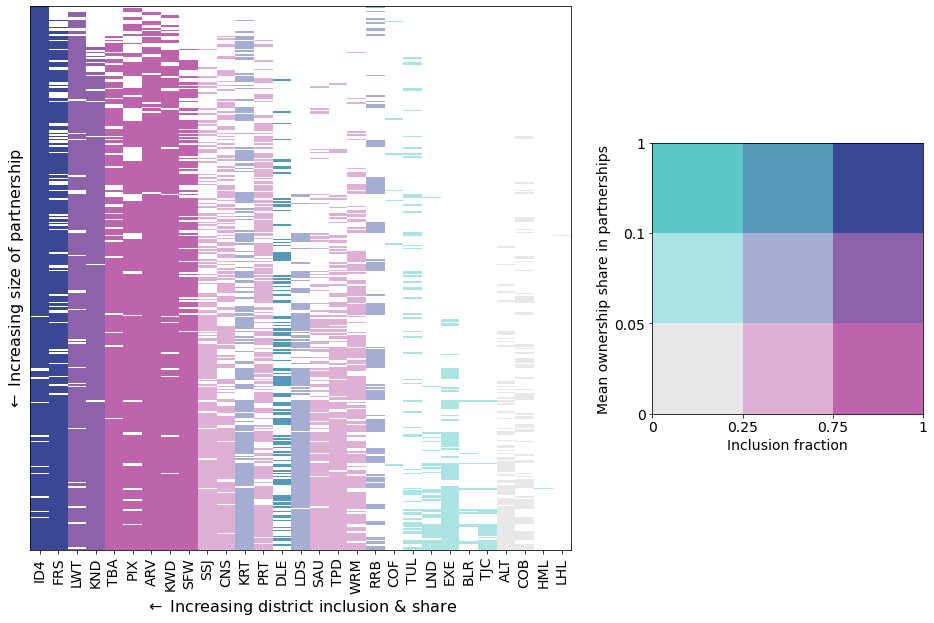

In [13]:
### test bivariate chloropleth 
fig, axs = plt.subplots(1,2, figsize=(16,10), gridspec_kw={'width_ratios': [0.66,0.33]})
ax = axs[0]

for d in range(ndistricts):
    count = 0
    stop = False
    for inclusion_bound in inclusion_bounds:
        for share_bound in share_bounds:
            if (not stop) and (np.mean(df_shares.iloc[:, d] > 0) < inclusion_bound):
                if (not stop) and (df_shares.iloc[:,d].loc[df_shares.iloc[:,d] > 0].mean() < share_bound):
                    color = jstevens[count]
                    stop = True
            count += 1

    for s in range(nsolns):
        share = df_shares.iloc[s, d]
        shareboxes = [Rectangle((d, s), 1, 1)]
        if share == 0.:
            alpha = 0
        else:
            alpha = 1
        pc = PatchCollection(shareboxes, facecolor=color, alpha=alpha)
        ax.add_collection(pc)
        
ax.set_ylim([0,nsolns])
ax.set_xlim([0,ndistricts])
ax.set_yticks([])
ax.set_ylabel(r'$\leftarrow$ Increasing size of partnership', fontsize=16)
ax.set_xlabel(r'$\leftarrow$ Increasing district inclusion & share', fontsize=16)
# _ = ax.set_xticks(np.arange(ndistricts - 0.5, 0, -1), labels=[], fontsize='14')
_ = ax.set_xticks(np.arange(0.5, ndistricts, 1), [s.split('_')[1] for s in df_shares.columns], fontsize='14', rotation=90)


ax = axs[1]
ax.set_aspect('equal', adjustable='box')
count = 0
xticks = [0]
yticks = [0]
for i,inclusion_bound in enumerate(inclusion_bounds):
    for j,share_bound in enumerate(share_bounds):
        shareboxes = [Rectangle((i,j), 1, 1)]
        pc = PatchCollection(shareboxes, facecolor=jstevens[count], alpha=1)
        count += 1
        ax.add_collection(pc)
        if i == 0:
            yticks.append(share_bound)
    xticks.append(inclusion_bound)

        
_=ax.set_xlim([0,len(share_bounds)])
_=ax.set_ylim([0,len(inclusion_bounds)])
_=ax.set_xticks(list(range(len(share_bounds)+1)), xticks, fontsize='14')
_=ax.set_xlabel('Inclusion fraction', fontsize='14')
_=ax.set_yticks(list(range(len(share_bounds)+1)), yticks, fontsize='14')
_=ax.set_ylabel('Mean ownership share in partnerships', fontsize='14')

In [14]:
results.columns

Index(['label', 'proj', 'share_FRS', 'share_COF', 'share_TUL', 'share_KWD',
       'share_EXE', 'share_LDS', 'share_LND', 'share_PRT', 'share_LWT',
       'share_TPD', 'share_SAU', 'share_TBA', 'share_PIX', 'share_DLE',
       'share_KRT', 'share_SSJ', 'share_SFW', 'share_NKN', 'share_ARV',
       'share_DLR', 'share_ID4', 'share_SMI', 'share_TJC', 'share_BLR',
       'share_LHL', 'share_BDM', 'share_WRM', 'share_COB', 'share_BVA',
       'share_CWO', 'share_HML', 'share_KND', 'share_RRB', 'share_CNS',
       'share_ALT', 'share_CWC', 'share_MAD', 'share_SOC', 'share_SOB',
       'share_CCA', 'share_OTL', 'share_OFK', 'cwg_p', 'ap_p', 'cwg_np',
       'cog_wp_p90', 'n_p', 'cog_wp_p50', 'cog_p_p90', 'cog_p_p50'],
      dtype='object')

### Analyze district-level distributions of outcomes using full MC

In [15]:
### get list of solns to highlight
# results.loc[results['ap_p'] == results['ap_p'].max(),:]

### get satisficing condition
satisfice = np.logical_and(np.logical_and(results['cwg_np'] >= 0, results['cog_wp_p90'] <= 200), results['n_p'] >= 5)
results.loc[satisfice].loc[results.loc[satisfice]['ap_p'] == results.loc[satisfice]['ap_p'].max()] 

,label,proj,share_FRS,share_COF,share_TUL,share_KWD,share_EXE,share_LDS,share_LND,share_PRT,...,share_OTL,share_OFK,cwg_p,ap_p,cwg_np,cog_wp_p90,n_p,cog_wp_p50,cog_p_p90,cog_p_p50
252,soln599,3.0,0.0,0.0,0.0,0.028898,0.0,0.0,0.0,0.0,...,0.0,0.0,87.91418,60.760748,7.841344,129.18517,9,108.835721,75.057229,58.457132


In [16]:
### first look at cwg_p-maximizing partnership
# soln = 'soln1224'

# ### cog_wp_p90-minimizing partership
# soln = 'soln2'

### n_p-maximizing partnership
# soln = 'soln196'

### ap_p-maximizing partnership
# soln = 'soln817'

### ap_p-max within satisficing partnerships
soln = 'soln599'

results_soln = results.loc[results['label'] == soln]
results_soln

,label,proj,share_FRS,share_COF,share_TUL,share_KWD,share_EXE,share_LDS,share_LND,share_PRT,...,share_OTL,share_OFK,cwg_p,ap_p,cwg_np,cog_wp_p90,n_p,cog_wp_p50,cog_p_p90,cog_p_p50
252,soln599,3.0,0.0,0.0,0.0,0.028898,0.0,0.0,0.0,0.0,...,0.0,0.0,87.91418,60.760748,7.841344,129.18517,9,108.835721,75.057229,58.457132


In [17]:
### get partners with nonzero shares, ordered by share
sharecols = [c for c in results_soln.columns if 'share' in c]
partners = [c.split('_')[1] for c in sharecols if results_soln[c].iloc[0] > 0]
shares = [results_soln[f'share_{c}'].iloc[0] for c in partners]
order = np.argsort(shares)[::-1]
shares = [shares[o] for o in order]
partners = [partners[o] for o in order]
print(shares)
print(partners)

[0.3191392024468319, 0.1864105571467451, 0.1242272650691411, 0.0951494278197535, 0.0783076943015253, 0.0781074636150386, 0.0759191819701662, 0.0288983424268736, 0.0138408652039242]
['ID4', 'ARV', 'PIX', 'SSJ', 'TBA', 'LWT', 'SFW', 'KWD', 'KND']


In [18]:
import h5py

kaf_to_gl = 1.23
baseline = 'soln1294'

with h5py.File('../results/WCU_results_s2/results.hdf5', 'r') as f:
    mc_soln = f[soln][...].transpose()
    mc_baseline = f[baseline][...].transpose()
    df_mc = pd.DataFrame(mc_soln - mc_baseline, index = ['mc' + mc for mc in f[soln].attrs['colnames']], columns = f[soln].attrs['rownames'])

## filter for cwg
df_mc = df_mc.loc[:, [f'{d}_avg_captured_water' for d in partners]] * kaf_to_gl
df_mc.columns = [f'{d}_cwg' for d in partners]
df_mc

,ID4_cwg,ARV_cwg,PIX_cwg,SSJ_cwg,TBA_cwg,LWT_cwg,SFW_cwg,KWD_cwg,KND_cwg
mc33,20.883312,18.642781,22.369299,6.034874,3.556206,10.509884,4.782915,8.754224,3.342608
mc34,22.669953,17.661563,16.153434,5.531111,3.786233,8.101749,3.977896,9.679127,3.395844
mc35,18.443944,12.795452,18.340853,6.035903,3.179601,6.598887,3.738579,7.333118,2.392632
mc36,19.653151,12.366204,25.315092,6.681145,4.175010,7.556496,4.469833,10.849617,2.904619
mc37,13.057874,8.217041,12.636945,2.943644,3.542723,3.904424,2.417579,2.862182,2.153268
...,...,...,...,...,...,...,...,...,...
mc92,20.911733,15.054807,21.290310,4.803201,3.298962,8.612166,3.661014,8.671399,2.996405
mc93,20.191793,26.534397,25.978497,8.098876,4.967384,15.038006,6.586709,12.580895,5.310371
mc94,20.162513,15.893435,14.153608,6.206586,3.407515,8.099609,4.292425,10.322293,2.810113
mc95,21.300279,15.401215,14.595406,5.946042,3.745972,7.482969,3.663172,5.955305,4.093043


In [19]:
print(df_mc.mean(axis=0).sum())

87.91418023976122


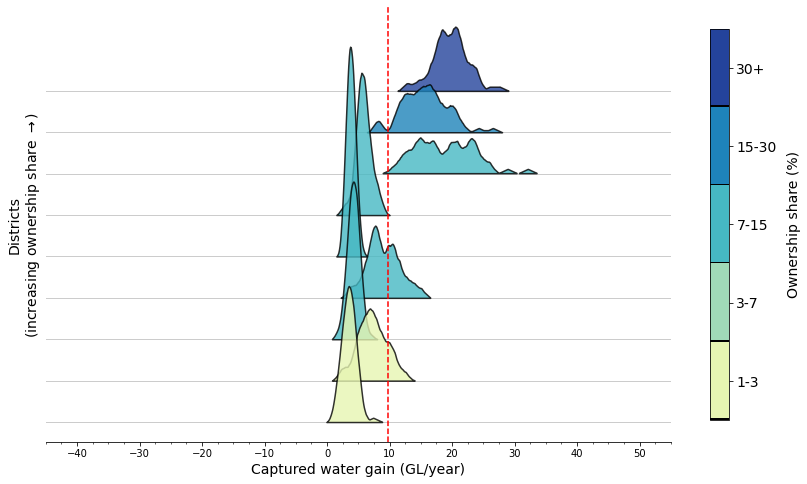

In [20]:
### ridge plot for CWG of each partner, using statsmodels triangular kde
import statsmodels.api as sm
from matplotlib import cm
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

fig, ax = plt.subplots(1, figsize=(14,8))
ridgesep = 0.1
xmin = -45
xmax = 55
for i,d in enumerate(partners):
    ### set bottom of "ridge" in decreasing order (smallest share at bottom)
    bottom = (-i * ridgesep)
    plt.axhline(bottom, color='0.8', zorder=1, lw=1)

    ### evaluate & plot kde
    c = f'{d}_cwg'
    kde_district = sm.nonparametric.KDEUnivariate(df_mc[c])
    kde_district.fit(kernel='tri', fft=False, bw=1.5)
    x = np.arange(xmin, xmax, 0.1)
    y = []
    for xx in x:
        yy = kde_district.evaluate(xx)
        if np.isnan(yy):
            y.append(0.)
        else:
            y.append(yy[0])
    y = np.array(y)
    color = cmap_class(shares[i])
    plt.fill_between(x, y + bottom, bottom, where=(y > 0.00005), lw=1.5, alpha=0.8, zorder=2, fc = color, ec = 'k')

plt.axvline(results_soln['cwg_p'].iloc[0] / len(partners), color='r', ls='--')
plt.yticks([])
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_minor_locator(MultipleLocator(2.5))

plt.xlim([xmin, xmax])
plt.ylabel('Districts\n' + r'(increasing ownership share $\rightarrow$)', fontsize=fontsize)
plt.xlabel('Captured water gain (GL/year)', fontsize=fontsize)
ax.spines[['top', 'left', 'right']].set_visible(False)


### add colorbar 
cb = plt.colorbar(mappable_even, ax=ax, ticks=[3/12,5/12,7/12,9/12,11/12], shrink=0.9)
_ = cb.ax.set_yticklabels(['1-3', '3-7','7-15','15-30','30+',], fontsize=fontsize)
_ = cb.set_label('Ownership share (%)', fontsize=fontsize, labelpad=10)
_ = cb.ax.set_ylim([2/12,1])

In [21]:
#### get annual paymetns for infrastructure
FKC_participant_payment = 50e6
CFWB_cost = 50e6
interest_annual = 0.03
time_horizon = 30
cap = 1000
projects = {0: 'none', 1: 'FKC', 2: 'CFWB', 3: 'FKC_CFWB'}
principle = {'none': 0., 'FKC': FKC_participant_payment, 'CFWB': CFWB_cost, 'FKC_CFWB': FKC_participant_payment + CFWB_cost}
payments_per_yr = 1
interest_rt = interest_annual / payments_per_yr
num_payments = time_horizon * payments_per_yr
annual_debt_payment_dict = {k: principle[k] / (((1 + interest_rt) ** num_payments - 1) / (interest_rt * (1 + interest_rt) ** num_payments)) for k in principle}

project = projects[results_soln['proj'].iloc[0]]
annual_debt_payment = annual_debt_payment_dict[project]

### get cost of gains in each MC sample for each partner
partner_shares = [results_soln[f'share_{d}'].iloc[0] for d in partners]
for i,d in enumerate(partners):
    df_mc[f'{d}_cog'] = (annual_debt_payment * partner_shares[i]) / df_mc[f'{d}_cwg'] / 1000
    df_mc[f'{d}_cog'].loc[df_mc[f'{d}_cog'] > cap] = cap
    df_mc[f'{d}_cog'].loc[df_mc[f'{d}_cog'] < 0] = cap
    
df_mc

,ID4_cwg,ARV_cwg,PIX_cwg,SSJ_cwg,TBA_cwg,LWT_cwg,SFW_cwg,KWD_cwg,KND_cwg,ID4_cog,ARV_cog,PIX_cog,SSJ_cog,TBA_cog,LWT_cog,SFW_cog,KWD_cog,KND_cog
mc33,20.883312,18.642781,22.369299,6.034874,3.556206,10.509884,4.782915,8.754224,3.342608,77.967736,51.014537,28.333400,80.440017,112.344458,37.916546,80.982832,16.841835,21.125741
mc34,22.669953,17.661563,16.153434,5.531111,3.786233,8.101749,3.977896,9.679127,3.395844,71.823023,53.848737,39.236133,87.766335,105.519139,49.186726,97.371589,15.232490,20.794558
mc35,18.443944,12.795452,18.340853,6.035903,3.179601,6.598887,3.738579,7.333118,2.392632,88.279630,74.327415,34.556642,80.426301,125.651021,60.388746,103.604604,20.105662,29.513552
mc36,19.653151,12.366204,25.315092,6.681145,4.175010,7.556496,4.469833,10.849617,2.904619,82.848016,76.907424,25.036382,72.659002,95.693207,52.735885,86.655153,13.589162,24.311301
mc37,13.057874,8.217041,12.636945,2.943644,3.542723,3.904424,2.417579,2.862182,2.153268,124.692927,115.741527,50.154395,164.913071,112.772034,102.063318,160.215671,51.512171,32.794376
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
mc92,20.911733,15.054807,21.290310,4.803201,3.298962,8.612166,3.661014,8.671399,2.996405,77.861772,63.172705,29.769331,101.067052,121.104785,46.271578,105.799667,17.002701,23.566598
mc93,20.191793,26.534397,25.978497,8.098876,4.967384,15.038006,6.586709,12.580895,5.310371,80.637938,35.842264,24.397035,59.939844,80.428657,26.499423,58.805400,11.719134,13.297578
mc94,20.162513,15.893435,14.153608,6.206586,3.407515,8.099609,4.292425,10.322293,2.810113,80.755042,59.839353,44.779982,78.214545,117.246746,49.199719,90.236646,14.283377,25.128903
mc95,21.300279,15.401215,14.595406,5.946042,3.745972,7.482969,3.663172,5.955305,4.093043,76.441468,61.751807,43.424506,81.641762,106.653248,53.254059,105.737321,24.757288,17.252461


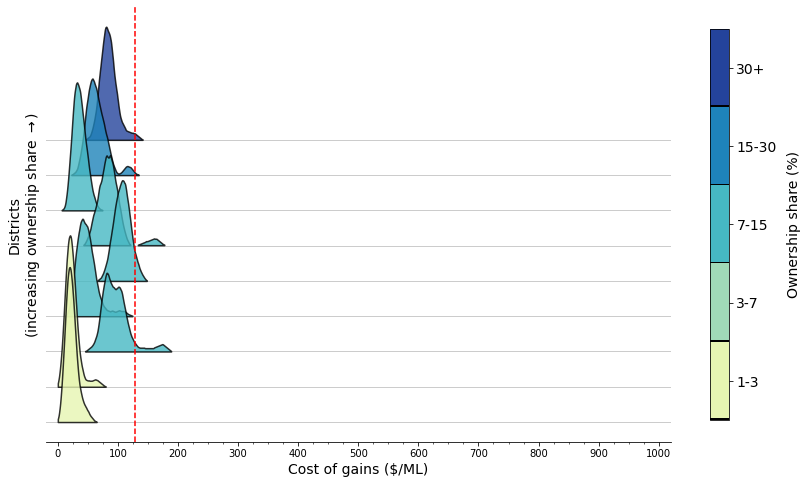

In [22]:
### ridge plot for COG of each partner, using statsmodels triangular kde
import statsmodels.api as sm

fig, ax = plt.subplots(1, figsize=(14,8))
ridgesep = 0.01
xmin = -20
xmax = 1020
for i,d in enumerate(partners):
    ### set bottom of "ridge" in decreasing order (smallest share at bottom)
    bottom = (-i * ridgesep)
    plt.axhline(bottom, color='0.8', zorder=1, lw=1)

    ### evaluate & plot kde
    c = f'{d}_cog'
    kde_district = sm.nonparametric.KDEUnivariate(df_mc[c])
    kde_district.fit(kernel='tri', fft=False, bw=15)
    x = np.arange(xmin, xmax, 0.5)
    y = []
    for xx in x:
        yy = kde_district.evaluate(xx)
        if np.isnan(yy):
            y.append(0.)
        else:
            y.append(yy[0])
    y = np.array(y)
    color = cmap_class(shares[i])
    plt.fill_between(x, y + bottom, bottom, where=np.logical_and(y > 0.0001, x >= 0), lw=1.5, alpha=0.8, zorder=2, fc = color, ec = 'k')

plt.axvline(results_soln['cog_wp_p90'].iloc[0], color='red', ls='--')
plt.yticks([])
ax.xaxis.set_major_locator(MultipleLocator(100))
ax.xaxis.set_minor_locator(MultipleLocator(25))

plt.xlim([xmin, xmax])
plt.ylabel('Districts\n' + r'(increasing ownership share $\rightarrow$)', fontsize=fontsize)
plt.xlabel('Cost of gains ($/ML)', fontsize=fontsize)
ax.spines[['top', 'left', 'right']].set_visible(False)

### add colorbar 
cb = plt.colorbar(mappable_even, ax=ax, ticks=[3/12,5/12,7/12,9/12,11/12], shrink=0.9)
_ = cb.ax.set_yticklabels(['1-3', '3-7','7-15','15-30','30+',], fontsize=fontsize)
_ = cb.set_label('Ownership share (%)', fontsize=fontsize, labelpad=10)
_ = cb.ax.set_ylim([2/12,1])

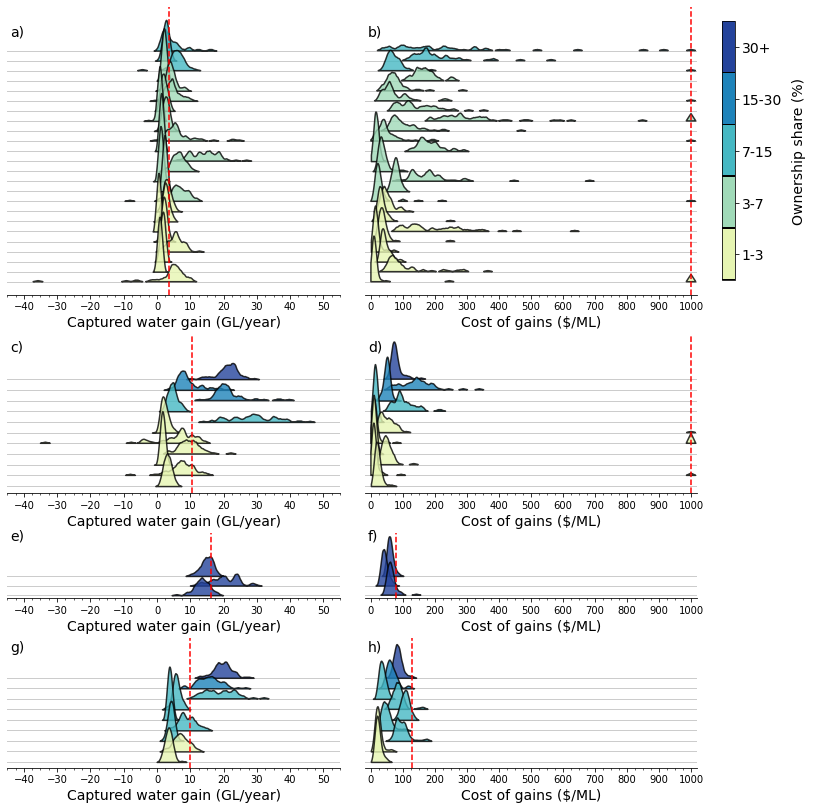

In [23]:
### 8-part figure with district-level CWG & COG MC results, 4 example partnerships
import matplotlib.gridspec as gridspec

solns = ['soln196', 'soln1224', 'soln2', 'soln599']
labels = [['a)', 'b)'], ['c)','d)'], ['e)','f)'], ['g)','h)']]
fig = plt.figure(figsize=(14,14))
gs = gridspec.GridSpec(nrows=4, ncols=3, height_ratios=[20,11,4.5,9], width_ratios=[5,5,1], hspace=0.25, wspace=0.1)
for row, soln in enumerate(solns):
    ax0 = fig.add_subplot(gs[row, 0])
    results_soln = results.loc[results['label'] == soln]
    
    ### get partners with nonzero shares, ordered by share
    sharecols = [c for c in results_soln.columns if 'share' in c]
    partners = [c.split('_')[1] for c in sharecols if results_soln[c].iloc[0] > 0]
    shares = [results_soln[f'share_{c}'].iloc[0] for c in partners]
    order = np.argsort(shares)[::-1]
    shares = [shares[o] for o in order]
    partners = [partners[o] for o in order]
    
    with h5py.File('../results/WCU_results_s2/results.hdf5', 'r') as f:
        mc_soln = f[soln][...].transpose()
        mc_baseline = f[baseline][...].transpose()
        df_mc = pd.DataFrame(mc_soln - mc_baseline, index = ['mc' + mc for mc in f[soln].attrs['colnames']], columns = f[soln].attrs['rownames'])

    ## filter for cwg
    cap = 1000
    df_mc = df_mc.loc[:, [f'{d}_avg_captured_water' for d in partners]] * kaf_to_gl
    df_mc.columns = [f'{d}_cwg' for d in partners]
    
    ### get cost of gains in each MC sample for each partner
    project = projects[results_soln['proj'].iloc[0]]
    annual_debt_payment = annual_debt_payment_dict[project]
    partner_shares = [results_soln[f'share_{d}'].iloc[0] for d in partners]
    for i,d in enumerate(partners):
        df_mc[f'{d}_cog'] = (annual_debt_payment * partner_shares[i]) / df_mc[f'{d}_cwg'] / 1000
        df_mc[f'{d}_cog'].loc[df_mc[f'{d}_cog'] > cap] = cap
        df_mc[f'{d}_cog'].loc[df_mc[f'{d}_cog'] < 0] = cap
    
    ridgesep = 0.1
    xmin = -45
    xmax = 55
    for i,d in enumerate(partners):
        ### set bottom of "ridge" in decreasing order (smallest share at bottom)
        bottom = (-i * ridgesep)
        ax0.axhline(bottom, color='0.8', zorder=1, lw=1)

        ### evaluate & plot kde
        c = f'{d}_cwg'
        kde_district = sm.nonparametric.KDEUnivariate(df_mc[c])
        kde_district.fit(kernel='tri', fft=False, bw=1.5)
        x = np.arange(xmin, xmax, 0.1)
        y = []
        for xx in x:
            yy = kde_district.evaluate(xx)
            if np.isnan(yy):
                y.append(0.)
            else:
                y.append(yy[0])
        y = np.array(y)
        color = cmap_class(shares[i])
        ax0.fill_between(x, y + bottom, bottom, where=(y > 0.00005), lw=1.5, alpha=0.8, zorder=2, fc = color, ec = 'k')

    ax0.axvline(results_soln['cwg_p'].iloc[0] / len(partners), color='r', ls='--')
    ax0.set_yticks([])
    ax0.xaxis.set_major_locator(MultipleLocator(10))
    ax0.xaxis.set_minor_locator(MultipleLocator(2.5))

    ax0.set_xlim([xmin, xmax])
#     ax0.set_ylabel('Districts')#\n' + r'(increasing ownership share $\rightarrow$)', fontsize=fontsize)
#     if row == 3:
    ax0.set_xlabel('Captured water gain (GL/year)', fontsize=fontsize)
    ax0.spines[['top', 'left', 'right']].set_visible(False)

    
    ### now do cost of gains figures
    ax1 = fig.add_subplot(gs[row, 1])
    ridgesep = 0.01
    xmin = -20
    xmax = 1020
    for i,d in enumerate(partners):
        ### set bottom of "ridge" in decreasing order (smallest share at bottom)
        bottom = (-i * ridgesep)
        ax1.axhline(bottom, color='0.8', zorder=1, lw=1)

        ### evaluate & plot kde
        c = f'{d}_cog'
        kde_district = sm.nonparametric.KDEUnivariate(df_mc[c])
        kde_district.fit(kernel='tri', fft=False, bw=15)
        x = np.arange(xmin, xmax, 0.5)
        y = []
        for xx in x:
            yy = kde_district.evaluate(xx)
            if np.isnan(yy):
                y.append(0.)
            else:
                y.append(yy[0])
        y = np.array(y)
        color = cmap_class(shares[i])
        ax1.fill_between(x, y + bottom, bottom, where=np.logical_and(y > 0.0001, x >= 0), lw=1.5, alpha=0.8, zorder=2, fc = color, ec = 'k')

    ax1.axvline(min(results_soln['cog_wp_p90'].iloc[0], cap), color='red', ls='--')
    ax1.set_yticks([])
    ax1.xaxis.set_major_locator(MultipleLocator(100))
    ax1.xaxis.set_minor_locator(MultipleLocator(25))

    ax1.set_xlim([xmin, xmax])
#     ax1.set_ylabel('Districts\n' + r'(increasing ownership share $\rightarrow$)', fontsize=fontsize)
#     if row == 3:
    ax1.set_xlabel('Cost of gains ($/ML)', fontsize=fontsize)
    ax1.spines[['top', 'left', 'right']].set_visible(False)

    ### adjust ylims so that right and left match
    ylim0 = ax0.get_ylim()
    ylim1 = ax1.get_ylim()
    ylim0_new = [min(ylim0[0], ylim1[0]*10), max(ylim0[1], ylim1[1]*10)]
    ylim1_new = [y/10 for y in ylim0_new]
    ax0.set_ylim(ylim0_new)
    ax1.set_ylim(ylim1_new)
    
    ### label subfigs
    ax0.annotate(labels[row][0], xy=(0.01,0.9), xycoords='axes fraction', fontsize=fontsize)
    ax1.annotate(labels[row][1], xy=(0.01,0.9), xycoords='axes fraction', fontsize=fontsize)

### add colorbar 
ax2 = fig.add_subplot(gs[0,2])
ax2.spines[['top', 'left', 'right', 'bottom']].set_visible(False)
ax2.set_xticks([])
ax2.set_yticks([])
cb = plt.colorbar(mappable_even, ax=ax2, ticks=[3/12,5/12,7/12,9/12,11/12], shrink=0.9, fraction=1)
_ = cb.ax.set_yticklabels(['1-3', '3-7','7-15','15-30','30+',], fontsize=fontsize)
_ = cb.set_label('Ownership share (%)', fontsize=fontsize, labelpad=10)
_ = cb.ax.set_ylim([2/12,1])

plt.savefig(f'{fig_dir}partners_cwg_cog_pdfs.png', bbox_inches='tight', dpi=300)


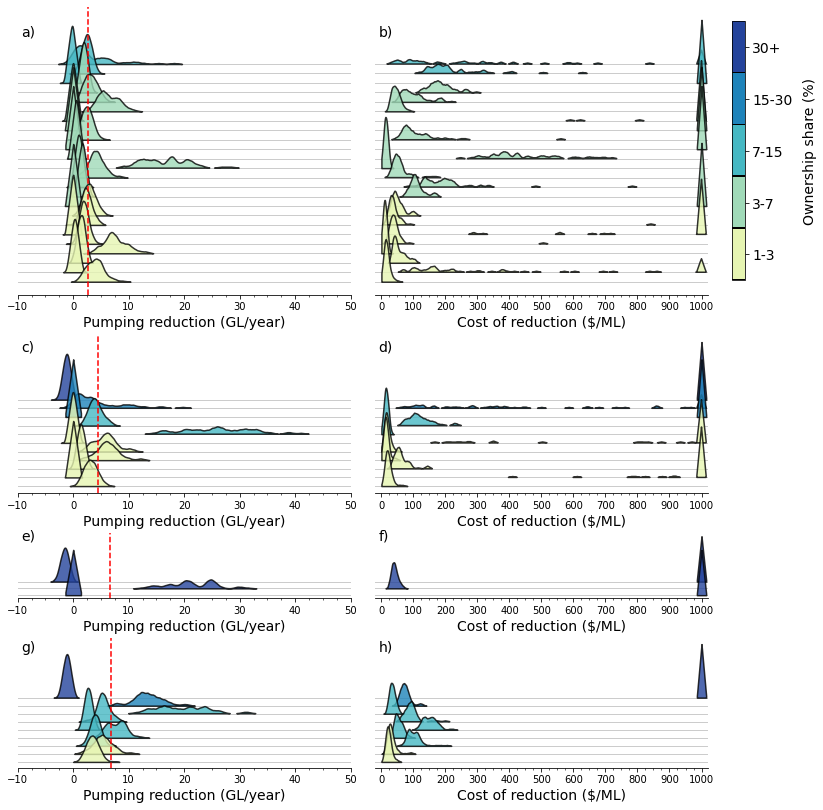

In [24]:
### 8-part figure with district-level pumping reduction (PR) & cost of reduction (CR) MC results, 4 example partnerships
import matplotlib.gridspec as gridspec

solns = ['soln196', 'soln1224', 'soln2', 'soln599']
labels = [['a)', 'b)'], ['c)','d)'], ['e)','f)'], ['g)','h)']]
fig = plt.figure(figsize=(14,14))
gs = gridspec.GridSpec(nrows=4, ncols=3, height_ratios=[20,11,4.5,9], width_ratios=[5,5,1], hspace=0.25, wspace=0.1)
for row, soln in enumerate(solns):
    ax0 = fig.add_subplot(gs[row, 0])
    results_soln = results.loc[results['label'] == soln]
    
    ### get partners with nonzero shares, ordered by share
    sharecols = [c for c in results_soln.columns if 'share' in c]
    partners = [c.split('_')[1] for c in sharecols if results_soln[c].iloc[0] > 0]
    shares = [results_soln[f'share_{c}'].iloc[0] for c in partners]
    order = np.argsort(shares)[::-1]
    shares = [shares[o] for o in order]
    partners = [partners[o] for o in order]
    
    with h5py.File('../results/WCU_results_s2/results.hdf5', 'r') as f:
        mc_soln = f[soln][...].transpose()
        mc_baseline = f[baseline][...].transpose()
        df_mc = pd.DataFrame(mc_baseline - mc_soln, index = ['mc' + mc for mc in f[soln].attrs['colnames']], columns = f[soln].attrs['rownames'])

    ## filter for pr
    cap = 1000
    df_mc = df_mc.loc[:, [f'{d}_avg_pumping' for d in partners]] * kaf_to_gl
    df_mc.columns = [f'{d}_pr' for d in partners]
    
    ### get cost of reductions in each MC sample for each partner
    project = projects[results_soln['proj'].iloc[0]]
    annual_debt_payment = annual_debt_payment_dict[project]
    partner_shares = [results_soln[f'share_{d}'].iloc[0] for d in partners]
    for i,d in enumerate(partners):
        df_mc[f'{d}_cor'] = (annual_debt_payment * partner_shares[i]) / df_mc[f'{d}_pr'] / 1000
        df_mc[f'{d}_cor'].loc[df_mc[f'{d}_cor'] > cap] = cap
        df_mc[f'{d}_cor'].loc[df_mc[f'{d}_cor'] < 0] = cap
    
    ridgesep = 0.1
    xmin = -10
    xmax = 50
    for i,d in enumerate(partners):
        ### set bottom of "ridge" in decreasing order (smallest share at bottom)
        bottom = (-i * ridgesep)
        ax0.axhline(bottom, color='0.8', zorder=1, lw=1)

        ### evaluate & plot kde
        c = f'{d}_pr'
        kde_district = sm.nonparametric.KDEUnivariate(df_mc[c])
        kde_district.fit(kernel='tri', fft=False, bw=1.5)
        x = np.arange(xmin, xmax, 0.1)
        y = []
        for xx in x:
            yy = kde_district.evaluate(xx)
            if np.isnan(yy):
                y.append(0.)
            else:
                y.append(yy[0])
        y = np.array(y)
        color = cmap_class(shares[i])
        ax0.fill_between(x, y + bottom, bottom, where=(y > 0.00005), lw=1.5, alpha=0.8, zorder=2, fc = color, ec = 'k')

    ax0.axvline(results_soln['ap_p'].iloc[0] / len(partners), color='r', ls='--')
    ax0.set_yticks([])
    ax0.xaxis.set_major_locator(MultipleLocator(10))
    ax0.xaxis.set_minor_locator(MultipleLocator(2.5))

    ax0.set_xlim([xmin, xmax])
#     ax0.set_ylabel('Districts')#\n' + r'(increasing ownership share $\rightarrow$)', fontsize=fontsize)
#     if row == 3:
    ax0.set_xlabel('Pumping reduction (GL/year)', fontsize=fontsize)
    ax0.spines[['top', 'left', 'right']].set_visible(False)

    
    ### now do cost of reductions figures
    ax1 = fig.add_subplot(gs[row, 1])
    ridgesep = 0.01
    xmin = -20
    xmax = 1020
    for i,d in enumerate(partners):
        ### set bottom of "ridge" in decreasing order (smallest share at bottom)
        bottom = (-i * ridgesep)
        ax1.axhline(bottom, color='0.8', zorder=1, lw=1)

        ### evaluate & plot kde
        c = f'{d}_cor'
        kde_district = sm.nonparametric.KDEUnivariate(df_mc[c])
        kde_district.fit(kernel='tri', fft=False, bw=15)
        x = np.arange(xmin, xmax, 0.5)
        y = []
        for xx in x:
            yy = kde_district.evaluate(xx)
            if np.isnan(yy):
                y.append(0.)
            else:
                y.append(yy[0])
        y = np.array(y)
        color = cmap_class(shares[i])
        ax1.fill_between(x, y + bottom, bottom, where=np.logical_and(y > 0.0001, x >= 0), lw=1.5, alpha=0.8, zorder=2, fc = color, ec = 'k')

#     ax1.axvline(min(results_soln['cog_wp_p90'].iloc[0], cap), color='red', ls='--')
    ax1.set_yticks([])
    ax1.xaxis.set_major_locator(MultipleLocator(100))
    ax1.xaxis.set_minor_locator(MultipleLocator(25))

    ax1.set_xlim([xmin, xmax])
#     ax1.set_ylabel('Districts\n' + r'(increasing ownership share $\rightarrow$)', fontsize=fontsize)
#     if row == 3:
    ax1.set_xlabel('Cost of reduction ($/ML)', fontsize=fontsize)
    ax1.spines[['top', 'left', 'right']].set_visible(False)

    ### adjust ylims so that right and left match
    ylim0 = ax0.get_ylim()
    ylim1 = ax1.get_ylim()
    ylim0_new = [min(ylim0[0], ylim1[0]*10), max(ylim0[1], ylim1[1]*10)]
    ylim1_new = [y/10 for y in ylim0_new]
    ax0.set_ylim(ylim0_new)
    ax1.set_ylim(ylim1_new)
    
    ### label subfigs
    ax0.annotate(labels[row][0], xy=(0.01,0.9), xycoords='axes fraction', fontsize=fontsize)
    ax1.annotate(labels[row][1], xy=(0.01,0.9), xycoords='axes fraction', fontsize=fontsize)

### add colorbar 
ax2 = fig.add_subplot(gs[0,2])
ax2.spines[['top', 'left', 'right', 'bottom']].set_visible(False)
ax2.set_xticks([])
ax2.set_yticks([])
cb = plt.colorbar(mappable_even, ax=ax2, ticks=[3/12,5/12,7/12,9/12,11/12], shrink=0.9, fraction=1)
_ = cb.ax.set_yticklabels(['1-3', '3-7','7-15','15-30','30+',], fontsize=fontsize)
_ = cb.set_label('Ownership share (%)', fontsize=fontsize, labelpad=10)
_ = cb.ax.set_ylim([2/12,1])

# plt.savefig(f'{fig_dir}partners_pr_cor_pdfs.png', bbox_inches='tight', dpi=300)


KND -14.670833693399715
OFK -25.976150840256413
OFK -14.34381984388425
OFK 10.425045875502413


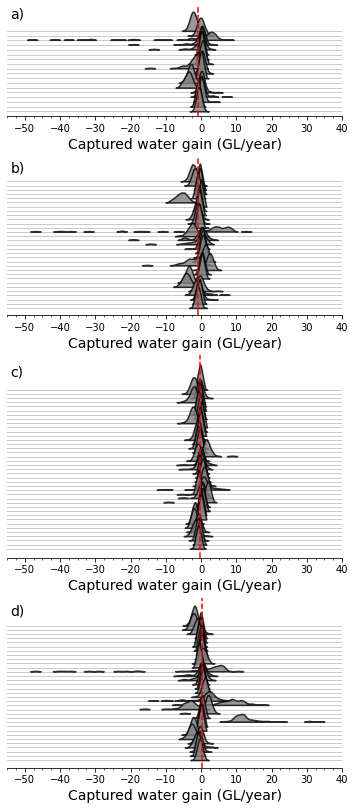

In [25]:
### repeat district-level CWG results for non-partners
import matplotlib.gridspec as gridspec

solns = ['soln196', 'soln1224', 'soln2', 'soln599']
labels = ['a)', 'b)', 'c)', 'd)']
fig = plt.figure(figsize=(6,14))
gs = gridspec.GridSpec(nrows=4, ncols=1, height_ratios=[40-20,40-11,40-3,40-9], width_ratios=[1], hspace=0.25, wspace=0.1)
for row, soln in enumerate(solns):
    ax0 = fig.add_subplot(gs[row, 0])
    results_soln = results.loc[results['label'] == soln]
    
    ### get nonpartners with zero shares
    sharecols = [c for c in results_soln.columns if 'share' in c]
    nonpartners = [c.split('_')[1] for c in sharecols if results_soln[c].iloc[0] == 0]
    
    with h5py.File('../results/WCU_results_s2/results.hdf5', 'r') as f:
        mc_soln = f[soln][...].transpose()
        mc_baseline = f[baseline][...].transpose()
        df_mc = pd.DataFrame(mc_soln - mc_baseline, index = ['mc' + mc for mc in f[soln].attrs['colnames']], columns = f[soln].attrs['rownames'])

    ## filter for cwg
    df_mc = df_mc.loc[:, [f'{d}_avg_captured_water' for d in nonpartners]] * kaf_to_gl
    df_mc.columns = [f'{d}_cwg' for d in nonpartners]
    print(d, df_mc.sum(axis=1).mean())
    
    ### ridgeplot
    ridgesep = 0.1
    xmin = -55
    xmax = 40
    for i,d in enumerate(nonpartners):
        ### set bottom of "ridge" in decreasing order (smallest share at bottom)
        bottom = (-i * ridgesep)
        ax0.axhline(bottom, color='0.8', zorder=1, lw=1)

        ### evaluate & plot kde
        c = f'{d}_cwg'
        kde_district = sm.nonparametric.KDEUnivariate(df_mc[c])
        kde_district.fit(kernel='tri', fft=False, bw=1.5)
        x = np.arange(xmin, xmax, 0.1)
        y = []
        for xx in x:
            yy = kde_district.evaluate(xx)
            if np.isnan(yy):
                y.append(0.)
            else:
                y.append(yy[0])
        y = np.array(y)
        color = '0.5'
        ax0.fill_between(x, y + bottom, bottom, where=(y > 0.00005), lw=1.5, alpha=0.8, zorder=2, fc = color, ec = 'k')

    ax0.axvline(results_soln['cwg_np'].iloc[0] / len(nonpartners), color='r', ls='--')
    ax0.set_yticks([])
    ax0.xaxis.set_major_locator(MultipleLocator(10))
    ax0.xaxis.set_minor_locator(MultipleLocator(2.5))

    ax0.set_xlim([xmin, xmax])
#     ax0.set_ylabel('Districts')#\n' + r'(increasing ownership share $\rightarrow$)', fontsize=fontsize)
#     if row == 3:
    ax0.set_xlabel('Captured water gain (GL/year)', fontsize=fontsize)
    ax0.spines[['top', 'left', 'right']].set_visible(False)
    
    ### label subfigs
    ax0.annotate(labels[row], xy=(0.01,0.9), xycoords='axes fraction', fontsize=fontsize)

plt.savefig(f'{fig_dir}nonpartners_cwg_pdfs.png', bbox_inches='tight', dpi=300)


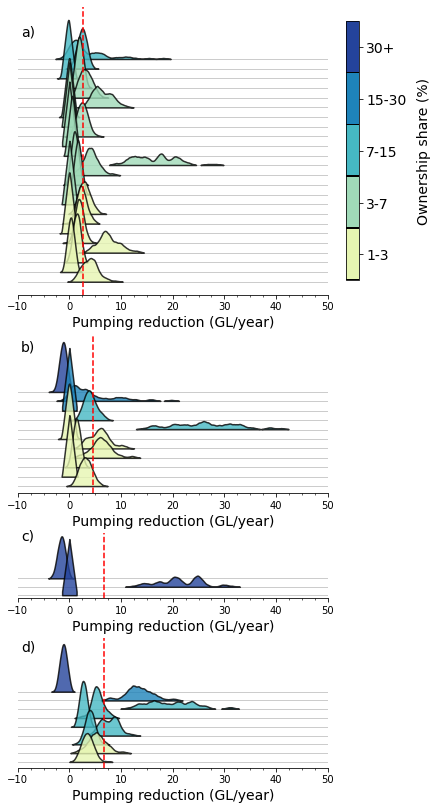

In [26]:
### 4-part figure with district-level AP MC results, 4 example partnerships
import matplotlib.gridspec as gridspec

solns = ['soln196', 'soln1224', 'soln2', 'soln599']
labels = ['a)', 'b)', 'c)','d)']
fig = plt.figure(figsize=(7,14))
gs = gridspec.GridSpec(nrows=4, ncols=2, height_ratios=[20,11,4.5,9], width_ratios=[5,1], hspace=0.25, wspace=0.1)
for row, soln in enumerate(solns):
    ax0 = fig.add_subplot(gs[row, 0])
    results_soln = results.loc[results['label'] == soln]
    
    ### get partners with nonzero shares, ordered by share
    sharecols = [c for c in results_soln.columns if 'share' in c]
    partners = [c.split('_')[1] for c in sharecols if results_soln[c].iloc[0] > 0]
    shares = [results_soln[f'share_{c}'].iloc[0] for c in partners]
    order = np.argsort(shares)[::-1]
    shares = [shares[o] for o in order]
    partners = [partners[o] for o in order]
    
    with h5py.File('../results/WCU_results_s2/results.hdf5', 'r') as f:
        mc_soln = f[soln][...].transpose()
        mc_baseline = f[baseline][...].transpose()
        df_mc = pd.DataFrame(mc_baseline - mc_soln, index = ['mc' + mc for mc in f[soln].attrs['colnames']], columns = f[soln].attrs['rownames'])

    ## filter for cwg
    df_mc = df_mc.loc[:, [f'{d}_avg_pumping' for d in partners]] * kaf_to_gl
    df_mc.columns = [f'{d}_ap' for d in partners]
    
    ridgesep = 0.1
    xmin = -10
    xmax = 50
    for i,d in enumerate(partners):
        ### set bottom of "ridge" in decreasing order (smallest share at bottom)
        bottom = (-i * ridgesep)
        ax0.axhline(bottom, color='0.8', zorder=1, lw=1)

        ### evaluate & plot kde
        c = f'{d}_ap'
        kde_district = sm.nonparametric.KDEUnivariate(df_mc[c])
        kde_district.fit(kernel='tri', fft=False, bw=1.5)
        x = np.arange(xmin, xmax, 0.1)
        y = []
        for xx in x:
            yy = kde_district.evaluate(xx)
            if np.isnan(yy):
                y.append(0.)
            else:
                y.append(yy[0])
        y = np.array(y)
        color = cmap_class(shares[i])
        ax0.fill_between(x, y + bottom, bottom, where=(y > 0.00005), lw=1.5, alpha=0.8, zorder=2, fc = color, ec = 'k')

    ax0.axvline(results_soln['ap_p'].iloc[0] / len(partners), color='r', ls='--')
    ax0.set_yticks([])
    ax0.xaxis.set_major_locator(MultipleLocator(10))
    ax0.xaxis.set_minor_locator(MultipleLocator(2.5))

    ax0.set_xlim([xmin, xmax])
#     ax0.set_ylabel('Districts')#\n' + r'(increasing ownership share $\rightarrow$)', fontsize=fontsize)
#     if row == 3:
    ax0.set_xlabel('Pumping reduction (GL/year)', fontsize=fontsize)
    ax0.spines[['top', 'left', 'right']].set_visible(False)

    
    ### label subfigs
    ax0.annotate(labels[row], xy=(0.01,0.9), xycoords='axes fraction', fontsize=fontsize)

### add colorbar 
ax2 = fig.add_subplot(gs[0,1])
ax2.spines[['top', 'left', 'right', 'bottom']].set_visible(False)
ax2.set_xticks([])
ax2.set_yticks([])
cb = plt.colorbar(mappable_even, ax=ax2, ticks=[3/12,5/12,7/12,9/12,11/12], shrink=0.9, fraction=1)
_ = cb.ax.set_yticklabels(['1-3', '3-7','7-15','15-30','30+',], fontsize=fontsize)
_ = cb.set_label('Ownership share (%)', fontsize=fontsize, labelpad=10)
_ = cb.ax.set_ylim([2/12,1])

plt.savefig(f'{fig_dir}partners_ap_pdfs.png', bbox_inches='tight', dpi=300)


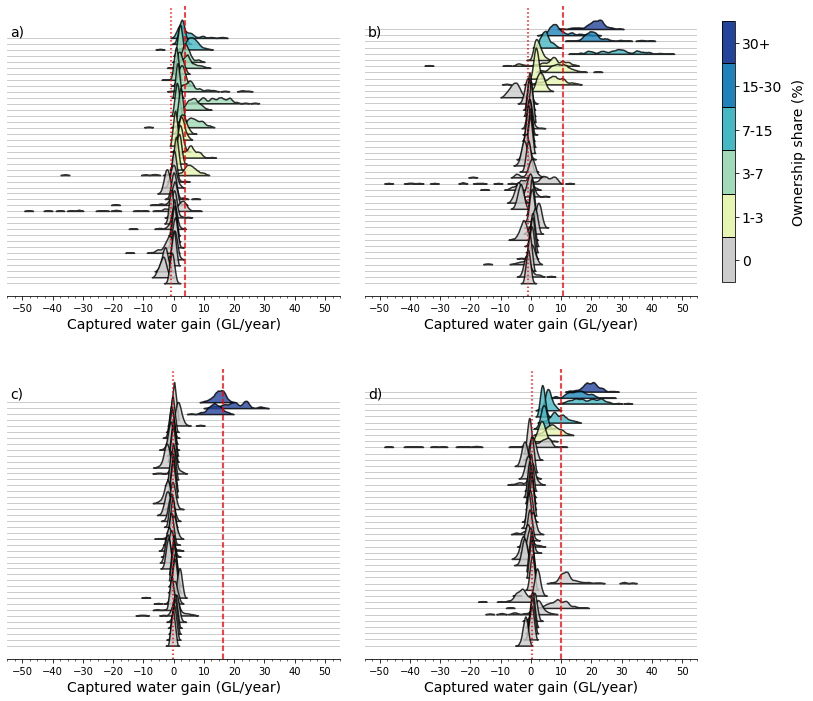

In [27]:
### 4-part figure with district-level AP MC results, for both partners & non-partnes, 4 example partnerships
import matplotlib.gridspec as gridspec

solns = ['soln196', 'soln1224', 'soln2', 'soln599']
labels = ['a)', 'b)', 'c)','d)']
fig = plt.figure(figsize=(14,12))
gs = gridspec.GridSpec(nrows=2, ncols=3, height_ratios=[1,1,], width_ratios=[5,5,1], hspace=0.25, wspace=0.1)
for count, soln in enumerate(solns):
    row = int(count/2)
    col = count % 2
    ax0 = fig.add_subplot(gs[row, col])
    results_soln = results.loc[results['label'] == soln]
    
    ### order all districts (partners + non-partners) by share
    sharecols = [c for c in results_soln.columns if 'share' in c]
    partners = [c.split('_')[1] for c in sharecols if results_soln[c].iloc[0] > 0]
    districts = [c.split('_')[1] for c in sharecols]
    shares = [results_soln[f'share_{c}'].iloc[0] for c in districts]
    order = np.argsort(shares)[::-1]
    shares = [shares[o] for o in order]
    districts = [districts[o] for o in order]
    
    with h5py.File('../results/WCU_results_s2/results.hdf5', 'r') as f:
        mc_soln = f[soln][...].transpose()
        mc_baseline = f[baseline][...].transpose()
        df_mc = pd.DataFrame(mc_soln - mc_baseline, index = ['mc' + mc for mc in f[soln].attrs['colnames']], columns = f[soln].attrs['rownames'])

    ## filter for cwg
    df_mc = df_mc.loc[:, [f'{d}_avg_captured_water' for d in districts]] * kaf_to_gl
    df_mc.columns = [f'{d}_cwg' for d in districts]
    
    ridgesep = 0.1
    xmin = -55
    xmax = 55
    for i,d in enumerate(districts):
        ### set bottom of "ridge" in decreasing order (smallest share at bottom)
        bottom = (-i * ridgesep)
        ax0.axhline(bottom, color='0.8', zorder=1, lw=1)

        ### evaluate & plot kde
        c = f'{d}_cwg'
        kde_district = sm.nonparametric.KDEUnivariate(df_mc[c])
        kde_district.fit(kernel='tri', fft=False, bw=1.5)
        x = np.arange(xmin, xmax, 0.1)
        y = []
        for xx in x:
            yy = kde_district.evaluate(xx)
            if np.isnan(yy):
                y.append(0.)
            else:
                y.append(yy[0])
        y = np.array(y)
        color = cmap_class(shares[i])
        ax0.fill_between(x, y + bottom, bottom, where=(y > 0.00005), lw=1.5, alpha=0.8, zorder=2, fc = color, ec = 'k')

    ax0.axvline(results_soln['cwg_p'].iloc[0] / len(partners), color='r', ls='--')
    ax0.axvline((df_mc.sum(axis=1).mean() - results_soln['cwg_p'].iloc[0]) / (len(districts) - len(partners)), color='r', ls=':')
    
    ax0.set_yticks([])
    ax0.xaxis.set_major_locator(MultipleLocator(10))
    ax0.xaxis.set_minor_locator(MultipleLocator(2.5))

    ax0.set_xlim([xmin, xmax])
#     ax0.set_ylabel('Districts')#\n' + r'(increasing ownership share $\rightarrow$)', fontsize=fontsize)
#     if row == 3:
    ax0.set_xlabel('Captured water gain (GL/year)', fontsize=fontsize)
    ax0.spines[['top', 'left', 'right']].set_visible(False)

    
    ### label subfigs
    ax0.annotate(labels[count], xy=(0.01,0.9), xycoords='axes fraction', fontsize=fontsize)

### add colorbar 
ax2 = fig.add_subplot(gs[0,2])
ax2.spines[['top', 'left', 'right', 'bottom']].set_visible(False)
ax2.set_xticks([])
ax2.set_yticks([])
cb = plt.colorbar(mappable_even, ax=ax2, ticks=[1/12,3/12,5/12,7/12,9/12,11/12], shrink=0.9, fraction=1)
_ = cb.ax.set_yticklabels(['0', '1-3', '3-7','7-15','15-30','30+',], fontsize=fontsize)
_ = cb.set_label('Ownership share (%)', fontsize=fontsize, labelpad=10)

plt.savefig(f'{fig_dir}alldistricts_cwg_pdfs.png', bbox_inches='tight', dpi=300)


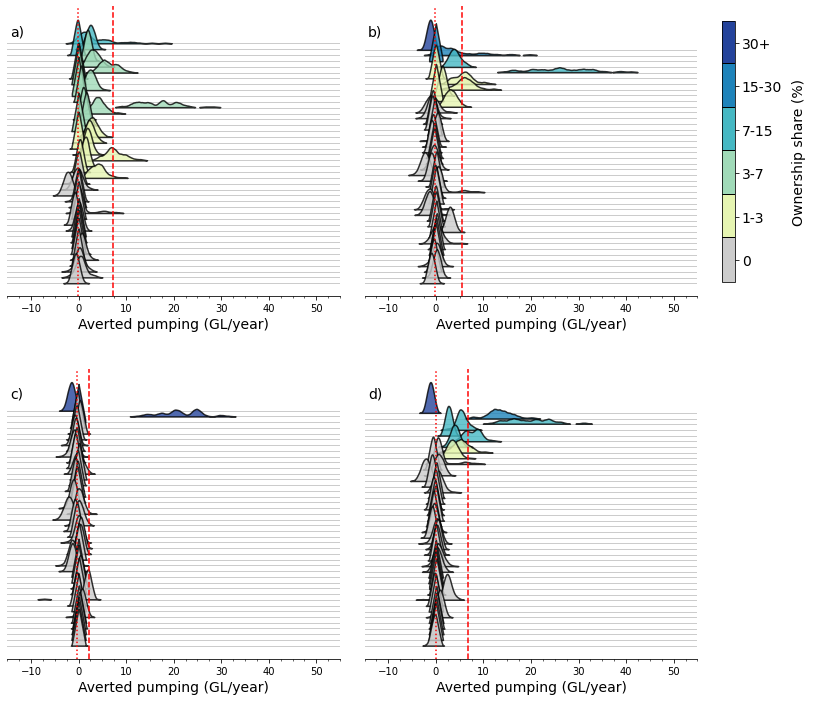

In [28]:
### 4-part figure with district-level AP MC results, for both partners & non-partnes, 4 example partnerships
import matplotlib.gridspec as gridspec

solns = ['soln196', 'soln1224', 'soln2', 'soln599']
labels = ['a)', 'b)', 'c)','d)']
fig = plt.figure(figsize=(14,12))
gs = gridspec.GridSpec(nrows=2, ncols=3, height_ratios=[1,1,], width_ratios=[5,5,1], hspace=0.25, wspace=0.1)
for count, soln in enumerate(solns):
    row = int(count/2)
    col = count % 2
    ax0 = fig.add_subplot(gs[row, col])
    results_soln = results.loc[results['label'] == soln]
    
    ### order all districts (partners + non-partners) by share
    sharecols = [c for c in results_soln.columns if 'share' in c]
    districts = [c.split('_')[1] for c in sharecols]
    shares = [results_soln[f'share_{c}'].iloc[0] for c in districts]
    order = np.argsort(shares)[::-1]
    shares = [shares[o] for o in order]
    districts = [districts[o] for o in order]
    
    with h5py.File('../results/WCU_results_s2/results.hdf5', 'r') as f:
        mc_soln = f[soln][...].transpose()
        mc_baseline = f[baseline][...].transpose()
        df_mc = pd.DataFrame(mc_baseline - mc_soln, index = ['mc' + mc for mc in f[soln].attrs['colnames']], columns = f[soln].attrs['rownames'])

    ## filter for cwg
    df_mc = df_mc.loc[:, [f'{d}_avg_pumping' for d in districts]] * kaf_to_gl
    df_mc.columns = [f'{d}_ap' for d in districts]
    
    ridgesep = 0.1
    xmin = -15
    xmax = 55
    for i,d in enumerate(districts):
        ### set bottom of "ridge" in decreasing order (smallest share at bottom)
        bottom = (-i * ridgesep)
        ax0.axhline(bottom, color='0.8', zorder=1, lw=1)

        ### evaluate & plot kde
        c = f'{d}_ap'
        kde_district = sm.nonparametric.KDEUnivariate(df_mc[c])
        kde_district.fit(kernel='tri', fft=False, bw=1.5)
        x = np.arange(xmin, xmax, 0.1)
        y = []
        for xx in x:
            yy = kde_district.evaluate(xx)
            if np.isnan(yy):
                y.append(0.)
            else:
                y.append(yy[0])
        y = np.array(y)
        color = cmap_class(shares[i])
        ax0.fill_between(x, y + bottom, bottom, where=(y > 0.00005), lw=1.5, alpha=0.8, zorder=2, fc = color, ec = 'k')

    ax0.axvline(results_soln['ap_p'].iloc[0] / len(partners), color='r', ls='--')
    ax0.axvline((df_mc.sum(axis=1).mean() - results_soln['ap_p'].iloc[0]) / (len(districts) - len(partners)), color='r', ls=':')
        
    ax0.set_yticks([])
    ax0.xaxis.set_major_locator(MultipleLocator(10))
    ax0.xaxis.set_minor_locator(MultipleLocator(2.5))

    ax0.set_xlim([xmin, xmax])
#     ax0.set_ylabel('Districts')#\n' + r'(increasing ownership share $\rightarrow$)', fontsize=fontsize)
#     if row == 3:
    ax0.set_xlabel('Averted pumping (GL/year)', fontsize=fontsize)
    ax0.spines[['top', 'left', 'right']].set_visible(False)

    
    ### label subfigs
    ax0.annotate(labels[count], xy=(0.01,0.9), xycoords='axes fraction', fontsize=fontsize)

### add colorbar 
ax2 = fig.add_subplot(gs[0,2])
ax2.spines[['top', 'left', 'right', 'bottom']].set_visible(False)
ax2.set_xticks([])
ax2.set_yticks([])
cb = plt.colorbar(mappable_even, ax=ax2, ticks=[1/12,3/12,5/12,7/12,9/12,11/12], shrink=0.9, fraction=1)
_ = cb.ax.set_yticklabels(['0', '1-3', '3-7','7-15','15-30','30+',], fontsize=fontsize)
_ = cb.set_label('Ownership share (%)', fontsize=fontsize, labelpad=10)

plt.savefig(f'{fig_dir}alldistricts_ap_pdfs.png', bbox_inches='tight', dpi=300)


### Maps

In [29]:
import geopandas as gpd

#local data folder name
project_folder = 'maps/ca_geo'
projection_string = 'EPSG:4326'#project raster to data projection
projection_num = 4326
point_location_filename = project_folder + '/CALFEWS_RESERVOIRS.csv'#coordinates of map 'points'
shapefile_folder = project_folder + '/CALFEWS_Shapes/'
districts_folder = project_folder + '/CALFEWS_shapes/Water_Districts/'
canal_folder = project_folder + '/CALFEWS_shapes/Canals_and_Aqueducts_local/'
raster_folder = project_folder + '/ca_satellite/'
outline_name = project_folder + '/CALFEWS_shapes/states.shp'#state outline


/home/alh/PycharmProjects/.venv_spatial/lib/python3.8/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [30]:
ag_keys = {
           'BDM': ['berrendamesawaterdistrict'], 'BLR': ['belridgewaterstoragedistrict'], 'BVA': ['buenavistawaterstoragedistrict'], 
           'CWO': ['cawelowaterdistrict'], 'HML': ['henrymillerwaterdistrict'], 'KND': ['kerndeltawaterdistrict'], 'LHL': ['losthillswaterdistrict'],
           'RRB': ['rosedale-riobravowaterstoragedistrict'], 'SMI': ['semitropicwaterservicedistrict'], 'THC': ['tehachapi-cummingscountywaterdistrict'], 
           'TJC': ['tejon-castacwaterdistrict'], 'WKN': ['westkernwaterdistrict'], 'WRM': ['wheelerridge-maricopawaterstoragedistrict'],
           'COB': ['bakersfieldcityof'], 'NKN': ['northkernwaterstoragedistrict'], 'ARV': ['arvin-edisonwaterstoragedistrict'],
           'PIX': ['pixleyirrigationdistrict'], 'DLE': ['delano-earlimartirrigationdistrict'], 'EXE': ['exeterirrigationdistrict'],
           'KRT': ['kern-tulare'], 'LND': ['lindmore'], 'LDS': ['lindsay-strathmoreirrigationdistric'],
           'LWT': ['lowertule'], 'PRT': ['portervilleirrigationdistrict'], 'SAU': ['saucelito'], 'SFW': ['shafter-wascoirrigationdistrict'],
           'SSJ': ['southernsanjoaquinmunicipalutilitydistrict'], 'TPD': ['teapot'], 'TBA': ['terrabellairrigationdistrict'], 'TUL': ['tulareirrigationdistrict'],
           'COF': ['fresnocityof'], 'FRS': ['fresnoirrigation'], 
           'DLR': ['dudleyridge'], 'TLB': ['tularelake'], 'KWD': ['kaweahdelta'], 'WSL': ['westlands'], 'SNL': ['sanluiswater'], 
           'PNC': ['panoche'], 'DLP': ['delpuerto'], 'CWC': ['chowchillawaterdistrict'], 'MAD': ['maderairrigationdistrict'], 
           'CNS': ['consolidated'], 'ALT': ['altairrigationdistrict'],  
           'KWB': ['kernwaterbank'],
         
          # 'OFK': ['hillsvalley', 'orangecoveirrigationdistrict','lewiscreek','lindsaycityof','stonecorral' ,
           #        'ivanhoeirrigationdistrict', 'orangecovecityof', 'tri-valleywaterdistrict', 'internationalwaterdistrict', 
            #       'garfield', 'hiddenlakes', 'fresnocountywaterworksdistrictno18'], #'gravely'
           'KRWA': ['kingsriverwaterdistrict'],#, 'kingsriverconservationdistrict'],
           #'OEX': ['sanluiscanalcompany', 'centralcalifornia', 'firebaughcanalcompany', 'columbiacanalcompany'],
           #'OCD': ['bantacarbonairrigationdistrict, byronbethanyirrigationdistrict', 'eaglefield', 'mercysprings',
            #       'oralomawaterdistrict', 'pajarovalleywatermanagementagency', 'pattersonwaterdistrict', 'westsidewaterdistrict',
             #      'weststanislaus', 'coelho','fresnoslough', 'jamesirrigationdistrict', 'lagunawaterdistrict',
              #     '1606', 'tranquilityirrigationdistrict', 'avenal', 'coalingacityof', 'huroncityof', 'pacheco', 
               #    'tranquilitypublicutilitydistrict']#, 'tracycityof'
          }

#                   'OXV': ['hillsvalley', 'tri-valleywaterdistrict']
#,                  'KCWA': 'kerncountywateragency', }
#                   'ID4': '4', 
#                   'OKW': 'otherkaweah',
            #       'OTL': 'othertule', 
#                  'OSW': 'otherswp', 

#                  'SOC': 'socal', 'SOB': 'southbay', 'CCA': 'centralcoast', 
          

In [31]:
districts_MOO = ["FRS","COF","TUL","KWD","EXE","LDS", "LND","PRT","LWT","TPD","SAU","TBA","PIX","DLE","KRT","SSJ", 
                 "SFW","NKN","ARV", "DLR","SMI","TJC","BLR","LHL","BDM","WRM","COB","BVA","CWO","HML",
                        "KND","RRB","CNS","ALT","CWC","MAD"] #"ID4","SOC","SOB","CCA"
ag_keys = {k: ag_keys[k] for k in districts_MOO}

In [32]:
def district_match(shp_names, name):
    shp_names_lc = [k.lower().strip().replace(' ','') for k in shp_names]
    is_match = [name in k for k in shp_names_lc]
    return [i for i in range(len(is_match)) if is_match[i]], [shp_names_lc[i] for i in range(len(is_match)) if is_match[i]]

### read in shapefile of all water districts
ags = gpd.read_file(districts_folder + 'Water_Districts.shp')
ags.sort_values('AGENCYNAME', inplace=True)

### filter to only keep districts in study area
idxs = []
names = []
keys = []
for k,vs in ag_keys.items():
    for v in vs:
        idx, name = district_match(ags.AGENCYNAME, v)
        idxs += idx
        names += name
        for i in range(len(idx)):
            keys.append(k)
            
ags = ags.iloc[idxs,:]
ags.reset_index(drop=True, inplace=True)
ags['area'] = ags.geometry.area
ags['district'] = keys
ags

/tmp/ipykernel_1239/4027625133.py:24: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  ags['area'] = ags.geometry.area


,OBJECTID,AGENCYNAME,SOURCE,AGENCYUNIQ,LASTMODIFI,MODIFIEDBY,SOURCECOMM,Date_Data_,GlobalID,geometry,area,district
0,32,Fresno Irrigation District,SCRO,961.0,2013-11-07T00:00:00.000Z,source,None,2013-11-07T00:00:00.000Z,{0EA9AE2A-51F2-4E0B-B3AA-E84D50D0DD42},"MULTIPOLYGON (((-119.73811 36.88710, -119.7379...",0.101195,FRS
1,180,Fresno City Of Service area,SCRO,934.0,2016-05-23T14:09:59.000Z,SERYSIAN,None,2013-11-07T00:00:00.000Z,{AA6B6103-329A-4605-A308-E734192C2597},"POLYGON ((-119.78829 36.89553, -119.78828 36.8...",0.036911,COF
2,66,Tulare Irrigation District,SCRO,2518.0,2013-11-07T00:00:00.000Z,source,None,2013-11-07T00:00:00.000Z,{21D33668-AA85-4E44-BBE6-A1F051A1003A},"MULTIPOLYGON (((-119.37348 36.27932, -119.3715...",0.027513,TUL
3,298,Kaweah Delta Water Conservation District,USBR-Federal,1278.0,2010-08-31T00:00:00.000Z,source,None,2010-08-31T00:00:00.000Z,{D6F406C5-16E7-433B-9287-1031BFF9232E},"POLYGON ((-119.21565 36.39227, -119.21570 36.3...",0.138077,KWD
4,76,Exeter Irrigation District,SCRO,864.0,2013-11-07T00:00:00.000Z,source,None,2013-11-07T00:00:00.000Z,{2F22D595-2D84-4D01-849A-FFCA293922D8},"POLYGON ((-119.06237 36.36879, -119.06256 36.3...",0.006080,EXE
5,75,Lindsay - Strathmore Irrigation District,SCRO,1433.0,2013-11-07T00:00:00.000Z,source,None,2013-11-07T00:00:00.000Z,{2684C64C-8EAA-46A5-851A-4C561C4A3EC2},"MULTIPOLYGON (((-119.08388 36.20368, -119.0824...",0.006526,LDS
6,77,Lindmore Irrigation District,SCRO,1431.0,2013-11-07T00:00:00.000Z,source,None,2013-11-07T00:00:00.000Z,{D15D4F24-D4D2-4136-8F8E-B6DF68186085},"MULTIPOLYGON (((-119.11845 36.24257, -119.1184...",0.011066,LND
7,78,Porterville Irrigation District,SCRO,1958.0,2013-11-07T00:00:00.000Z,source,None,2013-11-07T00:00:00.000Z,{40209707-9397-432C-B79D-67B8A8CD2502},"POLYGON ((-119.04665 36.03682, -119.04891 36.0...",0.006933,PRT
8,70,Lower Tule River Irrigation District,SCRO,1500.0,2017-01-10T10:03:55.000Z,SERYSIAN,None,2013-11-07T00:00:00.000Z,{C13BDBF9-E8BB-4C8C-9DD5-6D99198A939D},"POLYGON ((-119.14291 36.11640, -119.14296 36.1...",0.041511,LWT
9,79,Tea Pot Dome Water District,SCRO,2450.0,2013-11-07T00:00:00.000Z,source,None,2013-11-07T00:00:00.000Z,{A864C43D-79F2-4462-A1D0-FEAE51E08155},"MULTIPOLYGON (((-119.02229 36.00415, -119.0222...",0.001405,TPD


/home/alh/PycharmProjects/.venv_spatial/lib/python3.8/site-packages/geopandas/plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(
/home/alh/PycharmProjects/.venv_spatial/lib/python3.8/site-packages/geopandas/plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(
/home/alh/PycharmProjects/.venv_spatial/lib/python3.8/site-packages/geopandas/plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(
/home/alh/PycharmProjects/.venv_spatial/lib/python3.8/site-packages/geopandas/plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


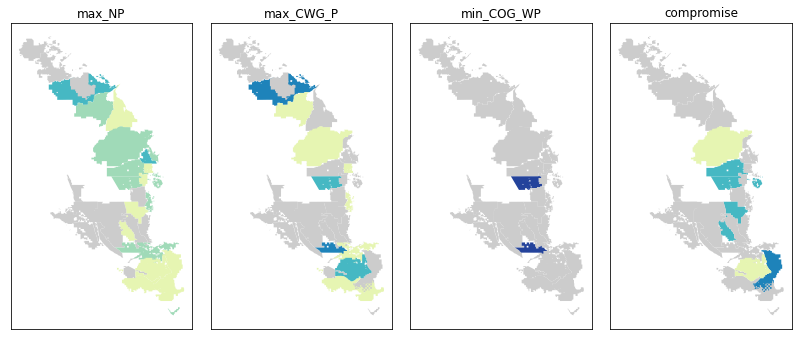

In [41]:
### share-colored maps for 4 example partnerships
fig = plt.figure(figsize=(14,14))
gs = gridspec.GridSpec(nrows=1, ncols=4, wspace=0.1)
for count, soln in enumerate(solns):
    ax0 = fig.add_subplot(gs[count])
    results_soln = results.loc[results['label'] == soln]
    
    ### order all districts (partners + non-partners) by share
    sharecols = [c for c in results_soln.columns if 'share' in c]
    districts = [c.split('_')[1] for c in sharecols]
    shares = [results_soln[f'share_{c}'].iloc[0] for c in districts]
    share_dict = {k: v for k,v in zip(districts, shares)}
    
    ### get shares for districts in gpd
    def get_share(d):
        try:
            share = share_dict[d]
        except:
            share = 0
        return share
            
    ags['share'] = [get_share(d) for d in ags['district']]
    ags['color_share'] = [cmap_class(s) for s in ags['share']]
    ags.plot('share', ax=ax0, color=ags['color_share'], alpha=1)
    ax0.set_xticks([])
    ax0.set_yticks([])
    ax0.set_title(label_dict[soln])
    
ags.head()

plt.savefig(f'{fig_dir}exPartnership_shares.png', bbox_inches='tight', dpi=300)


/home/alh/PycharmProjects/.venv_spatial/lib/python3.8/site-packages/geopandas/plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(
/home/alh/PycharmProjects/.venv_spatial/lib/python3.8/site-packages/geopandas/plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(
/home/alh/PycharmProjects/.venv_spatial/lib/python3.8/site-packages/geopandas/plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


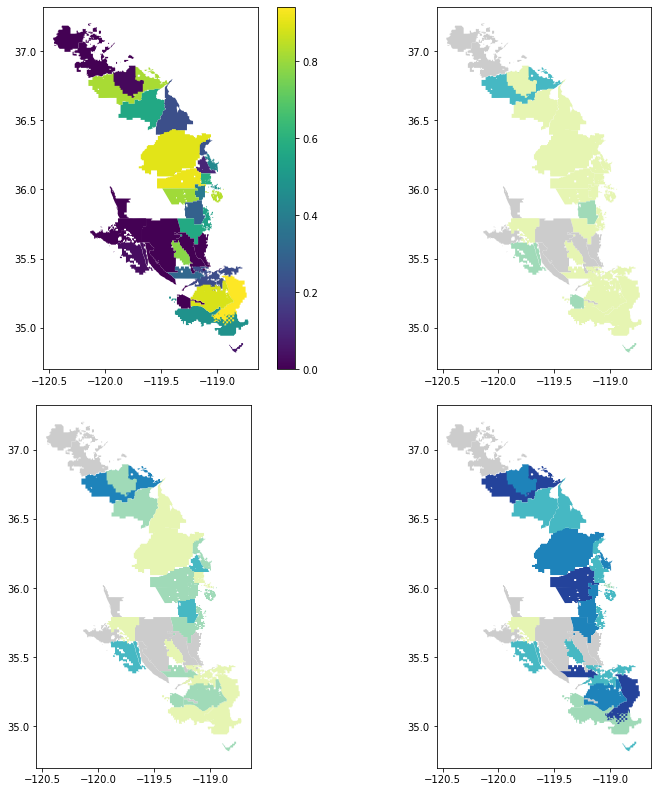

In [51]:
### maps showing the fraction of time each district is a partner, and its min/median/max share across all pareto partnerships 
fig = plt.figure(figsize=(14,14))
gs = gridspec.GridSpec(nrows=2, ncols=2, height_ratios=[1,1], width_ratios=[1,1], hspace=0.1, wspace=0.05)

### plot fraction inclusion for each district
ax = fig.add_subplot(gs[0, 0])
def get_inclusion_frac(d):
    try:
        frac = np.mean(df_shares['share_'+d] > 0)
    except:
        frac = 0
    return frac

ags['inclusion_frac'] = [get_inclusion_frac(d) for d in ags['district']]
ags.plot('inclusion_frac', ax=ax, legend=True)
ags.head()

### plot min share when included
ax = fig.add_subplot(gs[0, 1])
def get_min_share(d):
    try:
        share = np.min(df_shares['share_'+d].loc[df_shares['share_'+d] > 0])
    except:
        share = 0
    return share

ags['min_share'] = [get_min_share(d) for d in ags['district']]
ags['color_min_share'] = [cmap_class(s) for s in ags['min_share']]
ags.plot('min_share', ax=ax, color=ags['color_min_share'], legend=True)
ags.head()

### plot median share when included
ax = fig.add_subplot(gs[1, 0])
def get_min_share(d):
    try:
        share = np.median(df_shares['share_'+d].loc[df_shares['share_'+d] > 0])
    except:
        share = 0
    return share

ags['median_share'] = [get_min_share(d) for d in ags['district']]
ags['color_median_share'] = [cmap_class(s) for s in ags['median_share']]
ags.plot('median_share', ax=ax, color=ags['color_median_share'], legend=True)
ags.head()

### plot max share when included
ax = fig.add_subplot(gs[1, 1])
def get_min_share(d):
    try:
        share = np.max(df_shares['share_'+d].loc[df_shares['share_'+d] > 0])
    except:
        share = 0
    return share

ags['max_share'] = [get_min_share(d) for d in ags['district']]
ags['color_max_share'] = [cmap_class(s) for s in ags['max_share']]
ags.plot('max_share', ax=ax, color=ags['color_max_share'], legend=True)
ags.head()

plt.savefig(f'{fig_dir}district_share_distributions.png', bbox_inches='tight', dpi=300)


In [73]:
# # https://chart-studio.plotly.com/~empet/15191/texas-bivariate-choropleth-assoc/#/
# jstevens = ["#e8e8e8", "#ace4e4", "#5ac8c8", "#dfb0d6", "#a5add3", 
#             "#5698b9", "#be64ac", "#8c62aa", "#3b4994"]  # second example, pink/aqua

# # jstevens = ["#e8e8e8", "#e4acac", "#c85a5a", "#b0d5df", "#ad9ea5", 
# #             "#985356", "#64acbe", "#627f8c", "#574249"]  # first example, blue/red

# # jstevens = ["#e8e8e8", "#b0d5df",  "#64acbe", "#e4acac", "#ad9ea5", 
# #             "#627f8c", "#c85a5a", "#985356","#574249"]  # first example, but transpose

# share_bounds = [0.05, 0.1, 1]
# inclusion_bounds = [0.25, 0.75, 1]

jstevens = ['#E8E8E8', '#C5E0E0', '#A1D8D8', '#7ED0D0', '#5AC8C8',
            '#DEC7D9', '#BBBFD2', '#98B8CA', '#75B0C3', '#52A8BB',
            '#D3A6CA', '#B19FC3', '#8F98BC', '#6D90B5', '#4B89AE',
            '#C985BB', '#A87EB5', '#8677AE', '#6570A8', '#4369A1',
            '#BE64AC', '#9D5DA6', '#7D57A0', '#5C509A', '#3B4994']
share_bounds = [0.01, 0.03, 0.07, 0.15, 1]
inclusion_bounds = [0.01, 0.25, 0.5, 0.75, 1]


/home/alh/PycharmProjects/.venv_spatial/lib/python3.8/site-packages/geopandas/plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


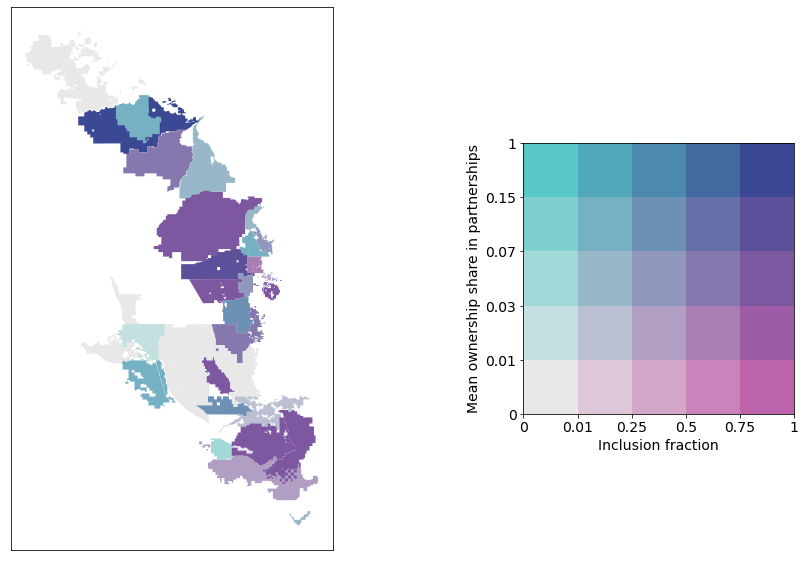

In [79]:
### test bivariate chloropleth 
fig, axs = plt.subplots(1,2, figsize=(16,10), gridspec_kw={'width_ratios': [0.66,0.33]})
ax = axs[0]

### plot fraction inclusion for each district
def get_bivariate_chloropleth_color(district):
    d = 'share_' + district
    try:
#         frac = np.mean(df_shares['share_'+d] > 0)
        count = 0
        stop = False
        for inclusion_bound in inclusion_bounds:
            for share_bound in share_bounds:
                if (not stop) and (np.mean(df_shares[d] > 0) < inclusion_bound):
                    if (not stop) and (df_shares[d].loc[df_shares[d] > 0].mean() < share_bound):
                        color = jstevens[count]
                        stop = True
                count += 1
    except:
        color = jstevens[0]
        
    return color

    
ags['min_share'] = [get_min_share(d) for d in ags['district']]
ags['color_bivariate'] = [get_bivariate_chloropleth_color(d) for d in ags['district']]
ags.plot('min_share', ax=ax, color=ags['color_bivariate'], legend=True)
ax.set_xticks([])
ax.set_yticks([])

ax = axs[1]
ax.set_aspect('equal', adjustable='box')
count = 0
xticks = [0]
yticks = [0]
for i,inclusion_bound in enumerate(inclusion_bounds):
    for j,share_bound in enumerate(share_bounds):
        shareboxes = [Rectangle((i,j), 1, 1)]
        pc = PatchCollection(shareboxes, facecolor=jstevens[count], alpha=1)
        count += 1
        ax.add_collection(pc)
        if i == 0:
            yticks.append(share_bound)
    xticks.append(inclusion_bound)

        
_=ax.set_xlim([0,len(share_bounds)])
_=ax.set_ylim([0,len(inclusion_bounds)])
_=ax.set_xticks(list(range(len(share_bounds)+1)), xticks, fontsize='14')
_=ax.set_xlabel('Inclusion fraction', fontsize='14')
_=ax.set_yticks(list(range(len(share_bounds)+1)), yticks, fontsize='14')
_=ax.set_ylabel('Mean ownership share in partnerships', fontsize='14')

plt.savefig(f'{fig_dir}district_share_distributions_bivariateChloropleth.png', bbox_inches='tight', dpi=300)
